# Building Machine Learning Systems with Python - Chapter 4

This code is supporting material for the book `Building Machine Learning Systems with Python` by [Willi Richert](https://www.linkedin.com/in/willirichert/) and [Luis Pedro Coelho](https://www.linkedin.com/in/luispedrocoelho/)  published by PACKT Publishing.

It is made available under the MIT License.

All code examples use Python in version...

In [1]:
import sys
sys.version

'3.7.3 (default, Mar 27 2019, 17:13:21) [MSC v.1915 64 bit (AMD64)]'

In [2]:
import numpy as np
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\gkanavenko\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# Downloading the data
In this chapter we will use the StackOverflow data from https://archive.org/download/stackexchange (while downloading, you have a couple hours time to contemplate whether now would be a good time to donate to the awesome archive.org :-) )

Since it is updated on a regular basis, you might get slightly different numbers. In this chapter we use this version:
```
stackoverflow.com-Posts.7z                        08-Dec-2017 22:31     11.3G
```
After downloading it, you need to unzip it with [7-Zip](http://www.7-zip.de/download.html).

# Extracting and filtering it

In [3]:
import os
import re
from collections import defaultdict
from tqdm import tqdm_notebook as tqdm # we all love nice progress bars, don't we?
try:
    import ujson as json  # UltraJSON if available
except:
    print("You can also use the normal json module, but you get a XXX speedup if you use ujson instead.")
    raise

In [4]:
# TODO change before merging to master
#DATA_DIR = "data"  # put your posts-2012.xml into this directory
DATA_DIR = r'data'

YEAR = 2017 # will restrict the data to posts from this year

fn_posts_all = os.path.join(DATA_DIR, "Posts.xml")
fn_posts = os.path.join(DATA_DIR, "posts-%i.xml" % YEAR)
fn_filtered = os.path.join(DATA_DIR, "filtered-%i.tsv" % YEAR)
fn_filtered_meta = os.path.join(DATA_DIR, "filtered-%i-meta.json" % YEAR)

In [5]:
SAMPLE_DIR = '%i' % YEAR
if not os.path.exists(SAMPLE_DIR):
    os.mkdir(SAMPLE_DIR)

if not os.path.exists(os.path.join(SAMPLE_DIR, 'data')):
    os.mkdir(os.path.join(SAMPLE_DIR, 'data'))

fn_sample = os.path.abspath(os.path.join(SAMPLE_DIR, 'data', "sample.tsv"))
fn_sample_meta = os.path.abspath(os.path.join(SAMPLE_DIR, 'data', "sample-meta.json"))
print("sample posts: %s" % fn_sample)
print("sample meta: %s" % fn_sample_meta)

CHART_DIR = os.path.join(SAMPLE_DIR, "charts")
if not os.path.exists(CHART_DIR):
    os.mkdir(CHART_DIR)

sample posts: D:\mlda\Building_Machine_Learning_Systems_with_Python\ch4\2017\data\sample.tsv
sample meta: D:\mlda\Building_Machine_Learning_Systems_with_Python\ch4\2017\data\sample-meta.json


The 59GB in posts.xml is contain posts from 2008 to 2017. We will use only some posts from the last year, which provides enough fun for now. We could simply grep on the command line, but that would take quite a while.

In [6]:
year_match = re.compile(r'^\s+<row [^>]*CreationDate="(\d+)-')
size = os.path.getsize(fn_posts_all)

def get_year(line):
    m = year_match.match(line)
    if m is None:
        return None
    return int(m.group(1))

print("Extracting all posts from %i ..." % YEAR)
with open(fn_posts_all, 'r', encoding='utf-8') as fa, open(fn_posts, 'w', encoding='utf-8') as f_year:
    # first two lines are the xml header and <posts> tag
    f_year.write('<?xml version="1.0" encoding="utf-8"?><posts>\n')    
    
    right = size//2
    delta = right
    
    # first find some post of YEAR
    while True:
        fa.seek(right)
        fa.readline() # go to next newline
        line = fa.readline()
        
        year = get_year(line)
        
        delta //= 2
        assert delta > 0
        
        if year>YEAR:
            right -= delta
        elif year<YEAR:
            right += delta
        else:
            break
            
    # then find where it starts
    left = right//2
    delta = left
    while True:
        fa.seek(left)
        fa.readline() # go to next newline
        line = fa.readline()
        
        year = get_year(line)
        
        delta //= 2
        if delta == 0:
            break
        
        if year<YEAR:
            left += delta
            
        else:
            left, right = left-delta, left
    
    # and write all posts of that year
    while True:
        line = fa.readline()
        year = get_year(line)
        if year == YEAR:
            f_year.write(line)
        elif year is None or year > YEAR:
            break
        
    # and write the closing tag
    f_year.write('</posts>')
print('... done!')

Extracting all posts from 2017 ...
... done!


In [7]:
from dateutil import parser as dateparser

from operator import itemgetter
from lxml import etree

NUM_ROWS = 5113519 # counted by hand

filtered_meta = {
    'question': {}, # question -> [(answer Id, Score), ...]
    'total': 0 # questions and answers finally written
}

# Regular expressions to find code snippets, links, and tags, which might help in 
# designing useful features
code_match = re.compile('<pre>(.*?)</pre>', re.MULTILINE | re.DOTALL)
link_match = re.compile('<a href="http://.*?".*?>(.*?)</a>', re.MULTILINE | re.DOTALL)
tag_match = re.compile('<[^>]*>', re.MULTILINE | re.DOTALL)
whitespace_match = re.compile(r'\s+', re.MULTILINE | re.DOTALL)

def extract_features_from_body(s):
    '''
    This method creates features from the raw post. It already contains all 
    features that we will use throughout the chapter.
    '''
    num_code_lines = 0
    link_count_in_code = 0
    code_free_s = s

    # remove source code and count how many lines
    for match_str in code_match.findall(s):
        num_code_lines += match_str.count('\n')
        code_free_s = code_match.sub(' ', code_free_s)

        # sometimes source code contain links, which we don't want to count
        link_count_in_code += len(link_match.findall(match_str))

    links = link_match.findall(s)
    link_count = len(links) - link_count_in_code

    html_free_s = tag_match.sub(' ', code_free_s)
    
    text = html_free_s
    for link in links:
        if link.lower().startswith('http://'):
            text = text.replace(link, ' ')

    text = whitespace_match.sub(' ', text)
    num_text_tokens = text.count(' ')

    return text, num_text_tokens, num_code_lines, link_count

num_questions = 0
num_answers = 0

def parsexml(fn):
    global num_questions, num_answers

    counter = 0

    # iterparse() returns a tuple (event, element). Since we request only
    # 'start' events, we pipe the result through an itemgetter that always returns
    # the 2nd result.
    it = map(itemgetter(1), etree.iterparse(fn, events=('start',)))
    
    # Get the <posts> element, in which we will parse the <row> elements. While doing so,
    # we will need the root handle to clear memory
    root = next(it)
    
    for counter, elem in enumerate(tqdm(it, total=NUM_ROWS)):
        
        if elem.tag != 'row':
            continue
            
        Id = int(elem.get('Id'))
        PostTypeId = int(elem.get('PostTypeId'))
        Score = int(elem.get('Score'))

        if PostTypeId == 1:
            num_questions += 1            
            ParentId = -1
            filtered_meta['question'][Id] = []
            
        elif PostTypeId == 2:
            num_answers += 1
            ParentId = int(elem.get('ParentId'))
            if not ParentId in filtered_meta['question']:
                # question is not from the same year so we have already dropped it
                continue

            filtered_meta['question'][ParentId].append((Id, Score))

        else:
            continue

        Text, NumTextTokens, NumCodeLines, LinkCount = extract_features_from_body(elem.get('Body'))

        # We have to tell lxml that this element is not used anymore. Otherwise, memory will blow up.
        # See https://www.ibm.com/developerworks/xml/library/x-hiperfparse for more information.
        elem.clear()
        while elem.getprevious() is not None:
            del elem.getparent()[0]
            
        values = (Id, ParentId, Score, NumTextTokens, NumCodeLines, LinkCount, Text)

        yield values

    print("Found %i posts" % counter)

if any(not os.path.exists(fn) for fn in [fn_filtered, fn_filtered_meta]):
    total = 0
    with open(fn_filtered, "w", encoding='utf-8') as f:
        for values in parsexml(fn_posts):
            line = "\t".join(map(str, values))
            f.write(line + "\n")
            total += 1
    filtered_meta['total'] = total
                
    with open(fn_filtered_meta, "w") as f:
        json.dump(filtered_meta, f)
    
    print("#qestions: %i" % num_questions)
    print("#answers: %i" % num_answers)
    
else:
    print("Skipping the conversion step, loading data from %s ..." % fn_filtered_meta)
    filtered_meta = json.load(open(fn_filtered_meta, "r"))
    print("... done!")

Skipping the conversion step, loading data from data\filtered-2017-meta.json ...
... done!


Now we need to select the answers that we want to keep per question. We do this in two stages:
 * Stage 1: Chosing questions that have a positive and negative answer and then chosing the most positive and negative.
 * Stage 2: Write out the features for those answers.

In [8]:
NUM_QUESTION_SAMPLE = 10000

posts_to_keep = set()
found_questions = 0

question = filtered_meta['question']

# Sorting the questions before iterating over them is only done for
# reproducability.
for ParentId, posts in tqdm(sorted(question.items()), desc="Stage 1:"):
    assert ParentId != -1

    if len(posts) < 2:
        continue

    neg_score_ids = []
    pos_score_ids = []
    
    for Id, Score in posts:
        if Score < 0:
            neg_score_ids.append((Score, Id))
        elif Score > 0:
            pos_score_ids.append((Score, Id))   

    if pos_score_ids and neg_score_ids:
        posts_to_keep.add(int(ParentId))

        posScore, posId = sorted(pos_score_ids)[-1]
        posts_to_keep.add(posId)

        negScore, negId = sorted(neg_score_ids)[0]
        posts_to_keep.add(negId)

        found_questions += 1

    if found_questions >= NUM_QUESTION_SAMPLE:
        break

In [9]:
already_written = set()
sample_meta = defaultdict(dict)

total = 0
kept = 0

with open(fn_sample, "w", encoding='utf-8') as f:
    for line in tqdm(open(fn_filtered, 'r', encoding='utf-8'), total=NUM_ROWS, desc="Stage 2:"):
        Id, ParentId, Score, NumTextTokens, NumCodeLines, LinkCount, Text = line.split("\t")

        Text = Text.strip()

        total += 1

        Id = int(Id)
        if Id in posts_to_keep:
            if Id in already_written:
                print(Id, "is already written")
                continue

            # setting meta info
            post = sample_meta[Id]
            post['ParentId'] = int(ParentId)
            post['Score'] = int(Score)
            post['NumTextTokens'] = int(NumTextTokens)
            post['NumCodeLines'] = int(NumCodeLines)
            post['LinkCount'] = int(LinkCount)
            post['idx'] = kept  # index into the TSV file

            if int(ParentId) == -1:
                q = sample_meta[Id]

                if not 'Answers' in q:
                    q['Answers'] = []

            else:
                q = sample_meta[int(ParentId)]

                if 'Answers' not in q:
                    q['Answers'] = [Id]
                else:
                    q['Answers'].append(Id)

            f.writelines("%s\t%s\n" % (Id, Text))
            kept += 1

with open(fn_sample_meta, "w") as fm:
    json.dump(sample_meta, fm)

print("read:", total)
print("kept:", kept)


read: 4657867
kept: 30000


## Utility functions

In [10]:
def load_meta(fn):
    meta = json.load(open(fn, "r"))
    
    # JSON only allows string keys, changing that to int
    for key in list(meta.keys()):
        meta[int(key)] = meta[key]
        del meta[key]

    return meta

meta = load_meta(fn_sample_meta)

def save_png(name):
    fn = 'B09124_04_%s.png'%name # please ignore, it just helps our publisher :-)
    plt.savefig(os.path.join(CHART_DIR, fn), bbox_inches="tight")

# Loading the features and labeling them

In [11]:
all_answers = sorted([a for a, v in meta.items() if v['ParentId'] != -1])

An answer is labeled as positive if it has a score greater than zero.

In [12]:
Y = np.asarray([meta[aid]['Score'] > 0 for aid in all_answers])
print(np.unique(Y, return_counts=True))
# We will need a couple iterations on X further down...

(array([False,  True]), array([10000, 10000], dtype=int64))


In [13]:
print(meta[41416669])

{'ParentId': 41416582, 'Score': 1, 'NumTextTokens': 102, 'NumCodeLines': 2, 'LinkCount': 0, 'idx': 43}


# Creating our first classifier: kNN using only LinkCount as a feature

So how good is `LinkCount`? Let's look at its histogram.

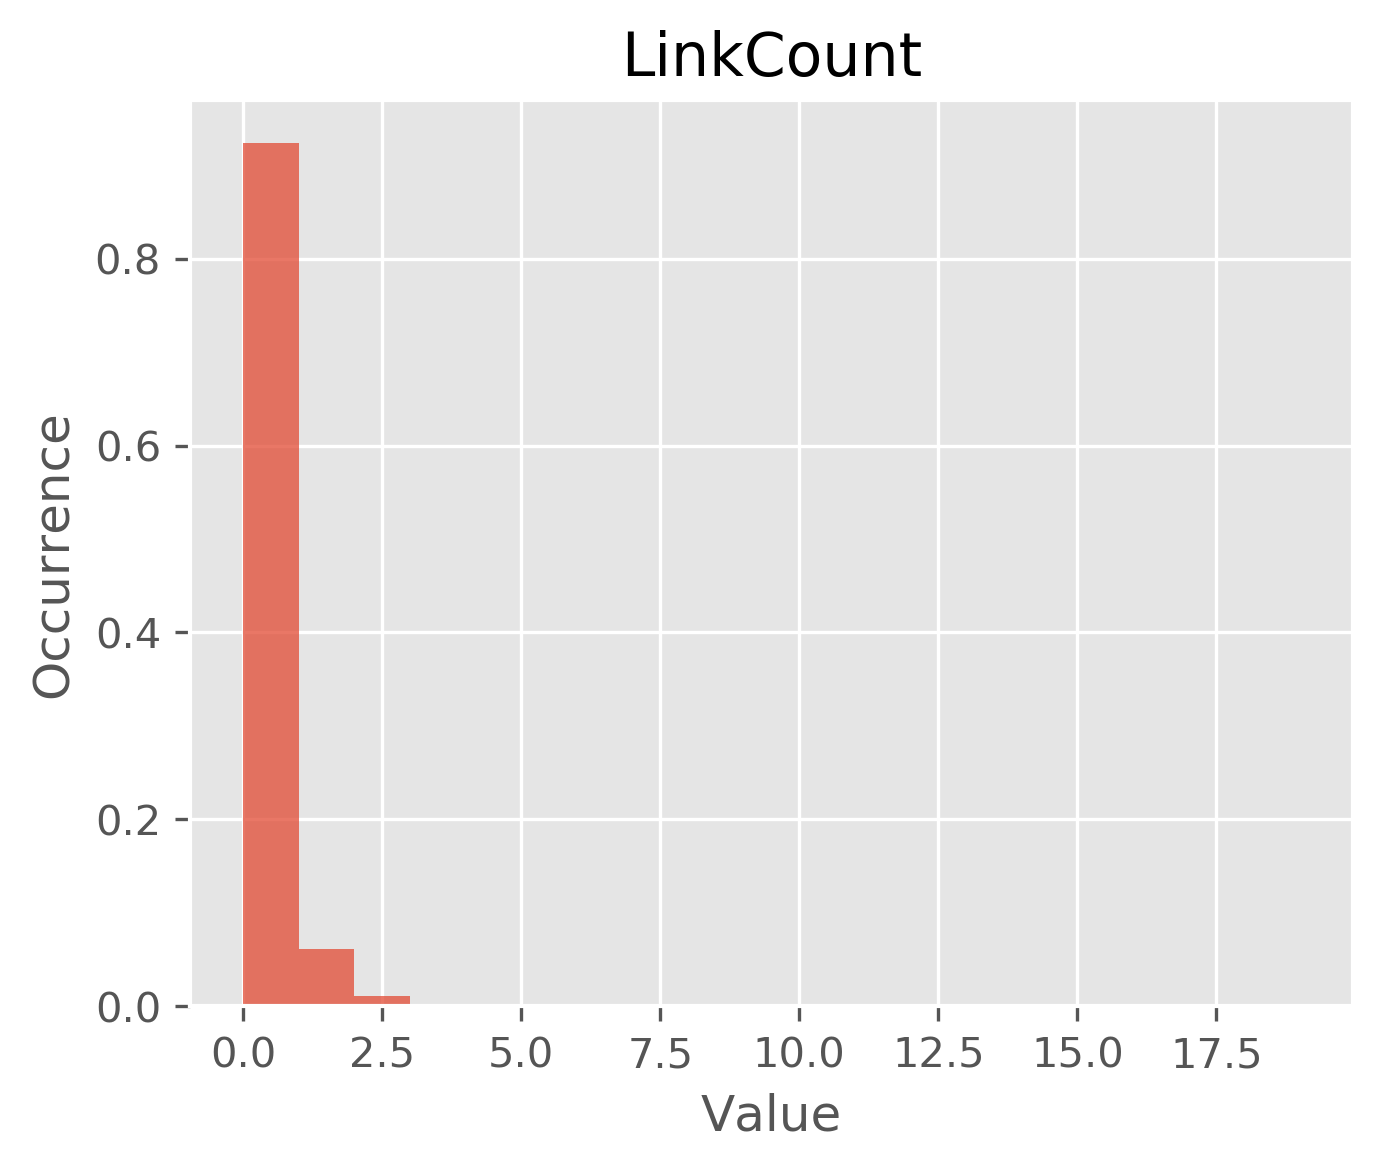

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

X = np.asarray([[meta[aid]['LinkCount']] for aid in all_answers])

plt.figure(figsize=(5,4), dpi=300) # width and height of the plot in inches

plt.title('LinkCount')
plt.xlabel('Value')
plt.ylabel('Occurrence')

n, bins, patches = plt.hist(X, density=1, bins=range(max(X.ravel())-min(X.ravel())), alpha=0.75)

plt.grid(True)
save_png('01_feat_hist_LinkCount')

Ok, so most posts don't contain a link at all, but let's try nevertheless...

## Training on LinkCount

In [15]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold

N_FOLDS = 10
cv = KFold(n_splits=N_FOLDS, shuffle=True, random_state=0)

scores = []
for train, test in tqdm(cv.split(X, Y)):
    clf = KNeighborsClassifier()
    clf.fit(X[train], Y[train])
    scores.append(clf.score(X[test], Y[test]))

print("Mean(scores)=%.5f\tStddev(scores)=%.5f"%(np.mean(scores), np.std(scores))) 


Mean(scores)=0.50670	Stddev(scores)=0.01848


In [16]:
print(scores)

[0.5045, 0.5035, 0.4865, 0.5095, 0.508, 0.494, 0.5275, 0.5505, 0.4935, 0.4895]


# Using more features

C:\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


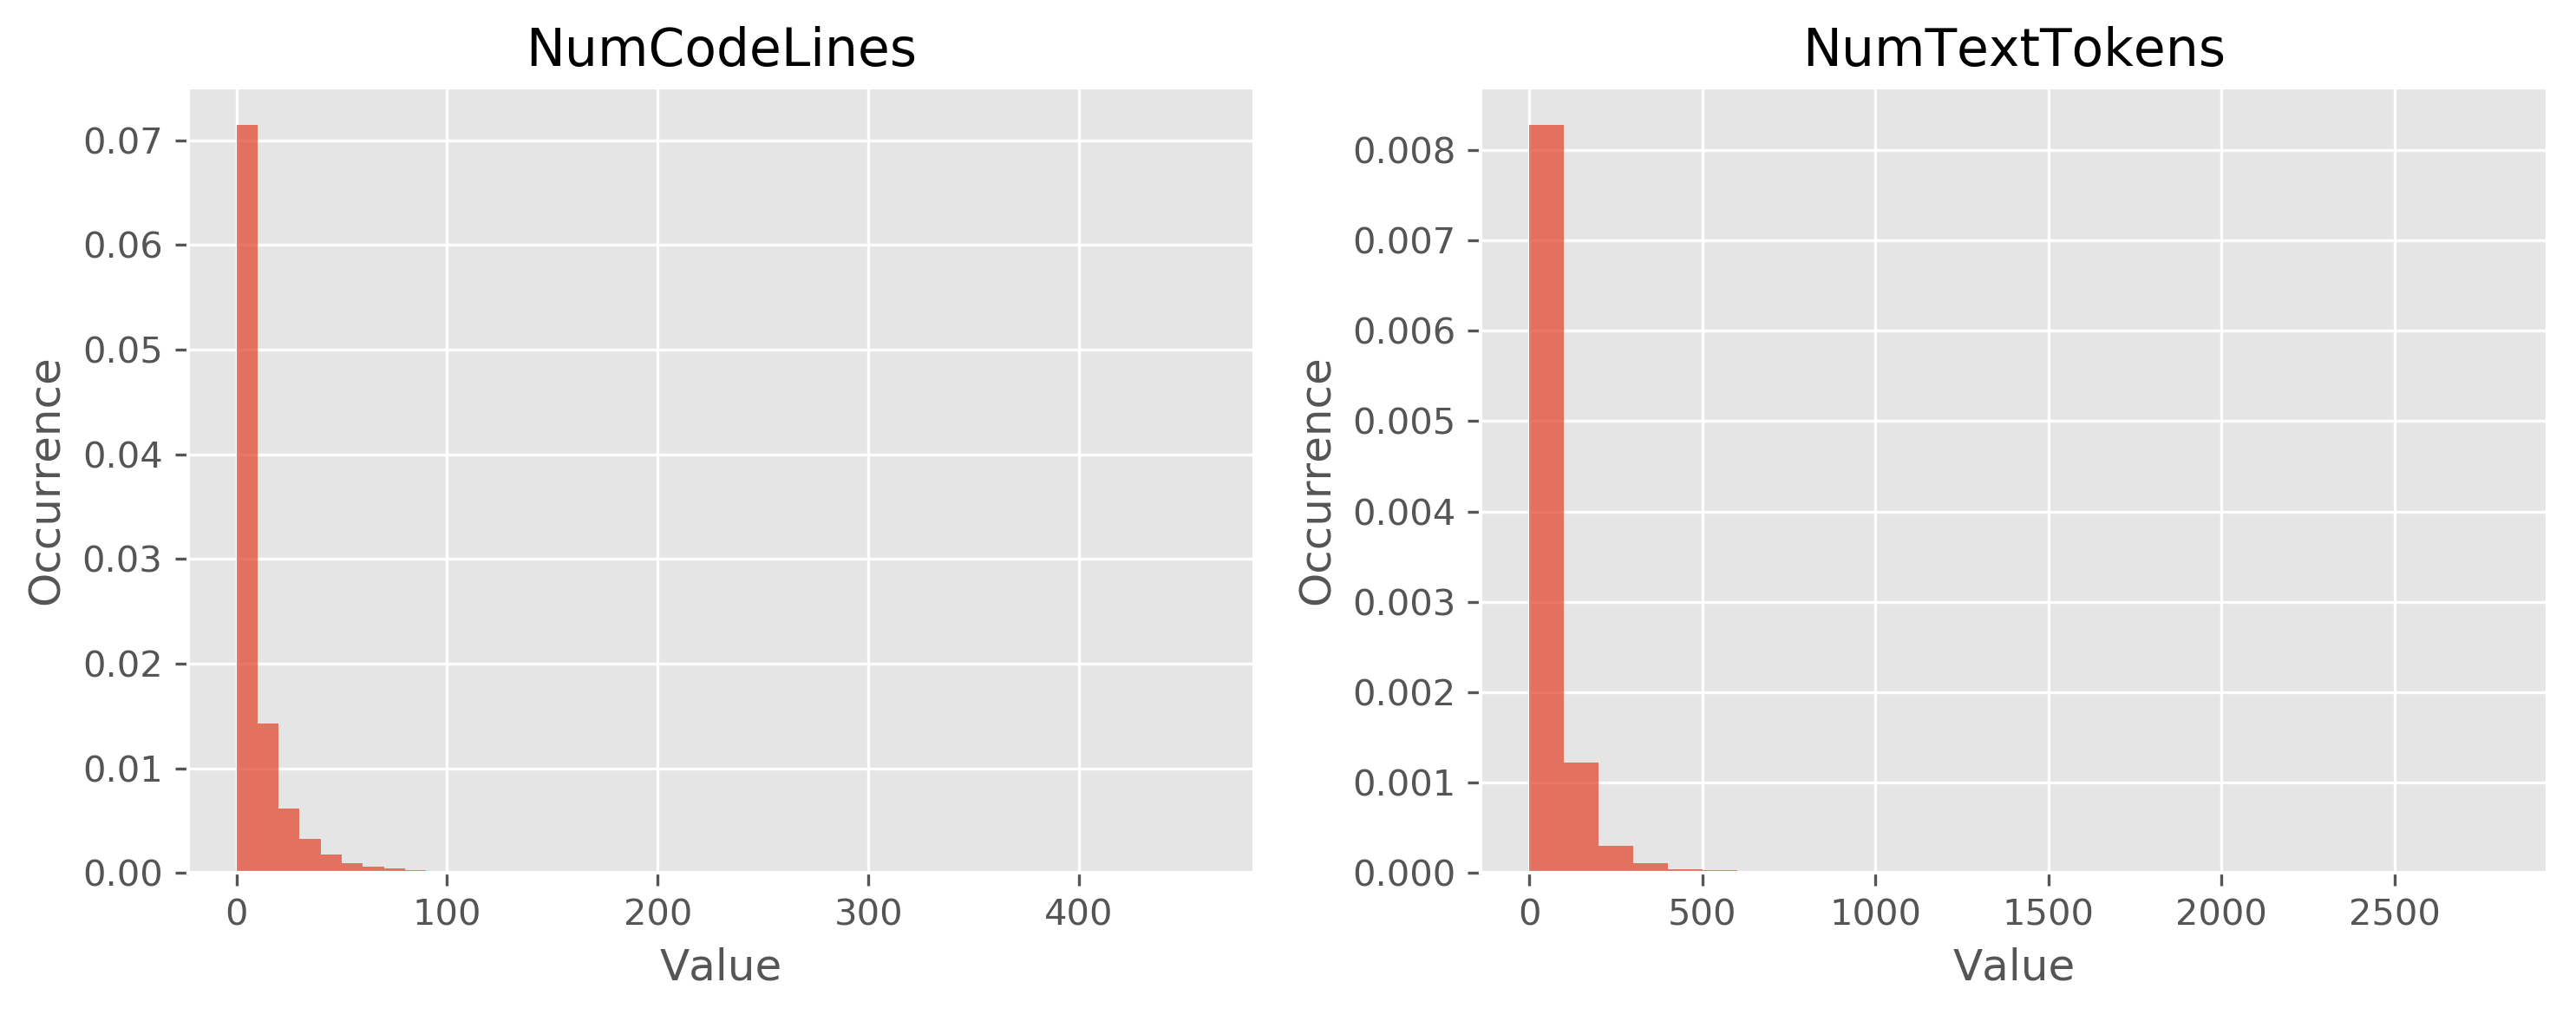

In [17]:
def plot_feat_hist(data_name_list, filename=None):
    if len(data_name_list) > 1:
        assert filename is not None

    num_rows = int(1 + (len(data_name_list) - 1) / 2)
    num_cols = int(1 if len(data_name_list) == 1 else 2)
    plt.figure(figsize=(5 * num_cols, 4 * num_rows), dpi=300)

    for i in range(num_rows):
        for j in range(num_cols):
            plt.subplot(num_rows, num_cols, 1 + i * num_cols + j)
            x, name = data_name_list[i * num_cols + j]
            plt.title(name)
            plt.xlabel('Value')
            plt.ylabel('Occurrence')
            
            max_val = max(x.ravel())
            if max_val>1000:
                bins = range(0, max_val, 100)
            elif max_val>100:
                bins = range(0, max_val, 10)
            else:
                bins = range(0, max_val)
            
            n, bins, patches = plt.hist(x, bins=bins, normed=1, alpha=0.75)

            plt.grid(True)
            plt.tight_layout()
    
    if not filename:
        filename = "feat_hist_%s" % name.replace(" ", "_")

    save_png(filename)


plot_feat_hist([(np.asarray([[meta[aid]['NumCodeLines']] for aid in all_answers]), 'NumCodeLines'),
                (np.asarray([[meta[aid]['NumTextTokens']] for aid in all_answers]), 'NumTextTokens')],
              '02_feat_hist_CodeLines_TextTokens');

Since the features vary in their value ranges, we need to standardize them using `StandardScaler()` so that kNN does not bias towards features having larger value intervals. 

In [18]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

def get_features(aid, feature_names):
    return tuple(meta[aid][fn] for fn in feature_names)

X = np.asarray([get_features(aid, ['LinkCount', 'NumCodeLines', 'NumTextTokens']) for aid in all_answers], float)

scores = []
for train, test in tqdm(cv.split(X, Y), total=N_FOLDS):
    clf = make_pipeline(StandardScaler(), KNeighborsClassifier())
    clf.fit(X[train], Y[train])
    scores.append(clf.score(X[test], Y[test]))

print("Mean(scores)=%.5f\tStddev(scores)=%.5f"%(np.mean(scores), np.std(scores))) 


Mean(scores)=0.60410	Stddev(scores)=0.00949


# Designing more features
Let's create some more text based features like average sentence and word length, how many words are CAPITALIZED or contain exclamation marks.

We simply fetch the post texts, calculate the statistics and add them to the `meta` dictionary.

C:\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


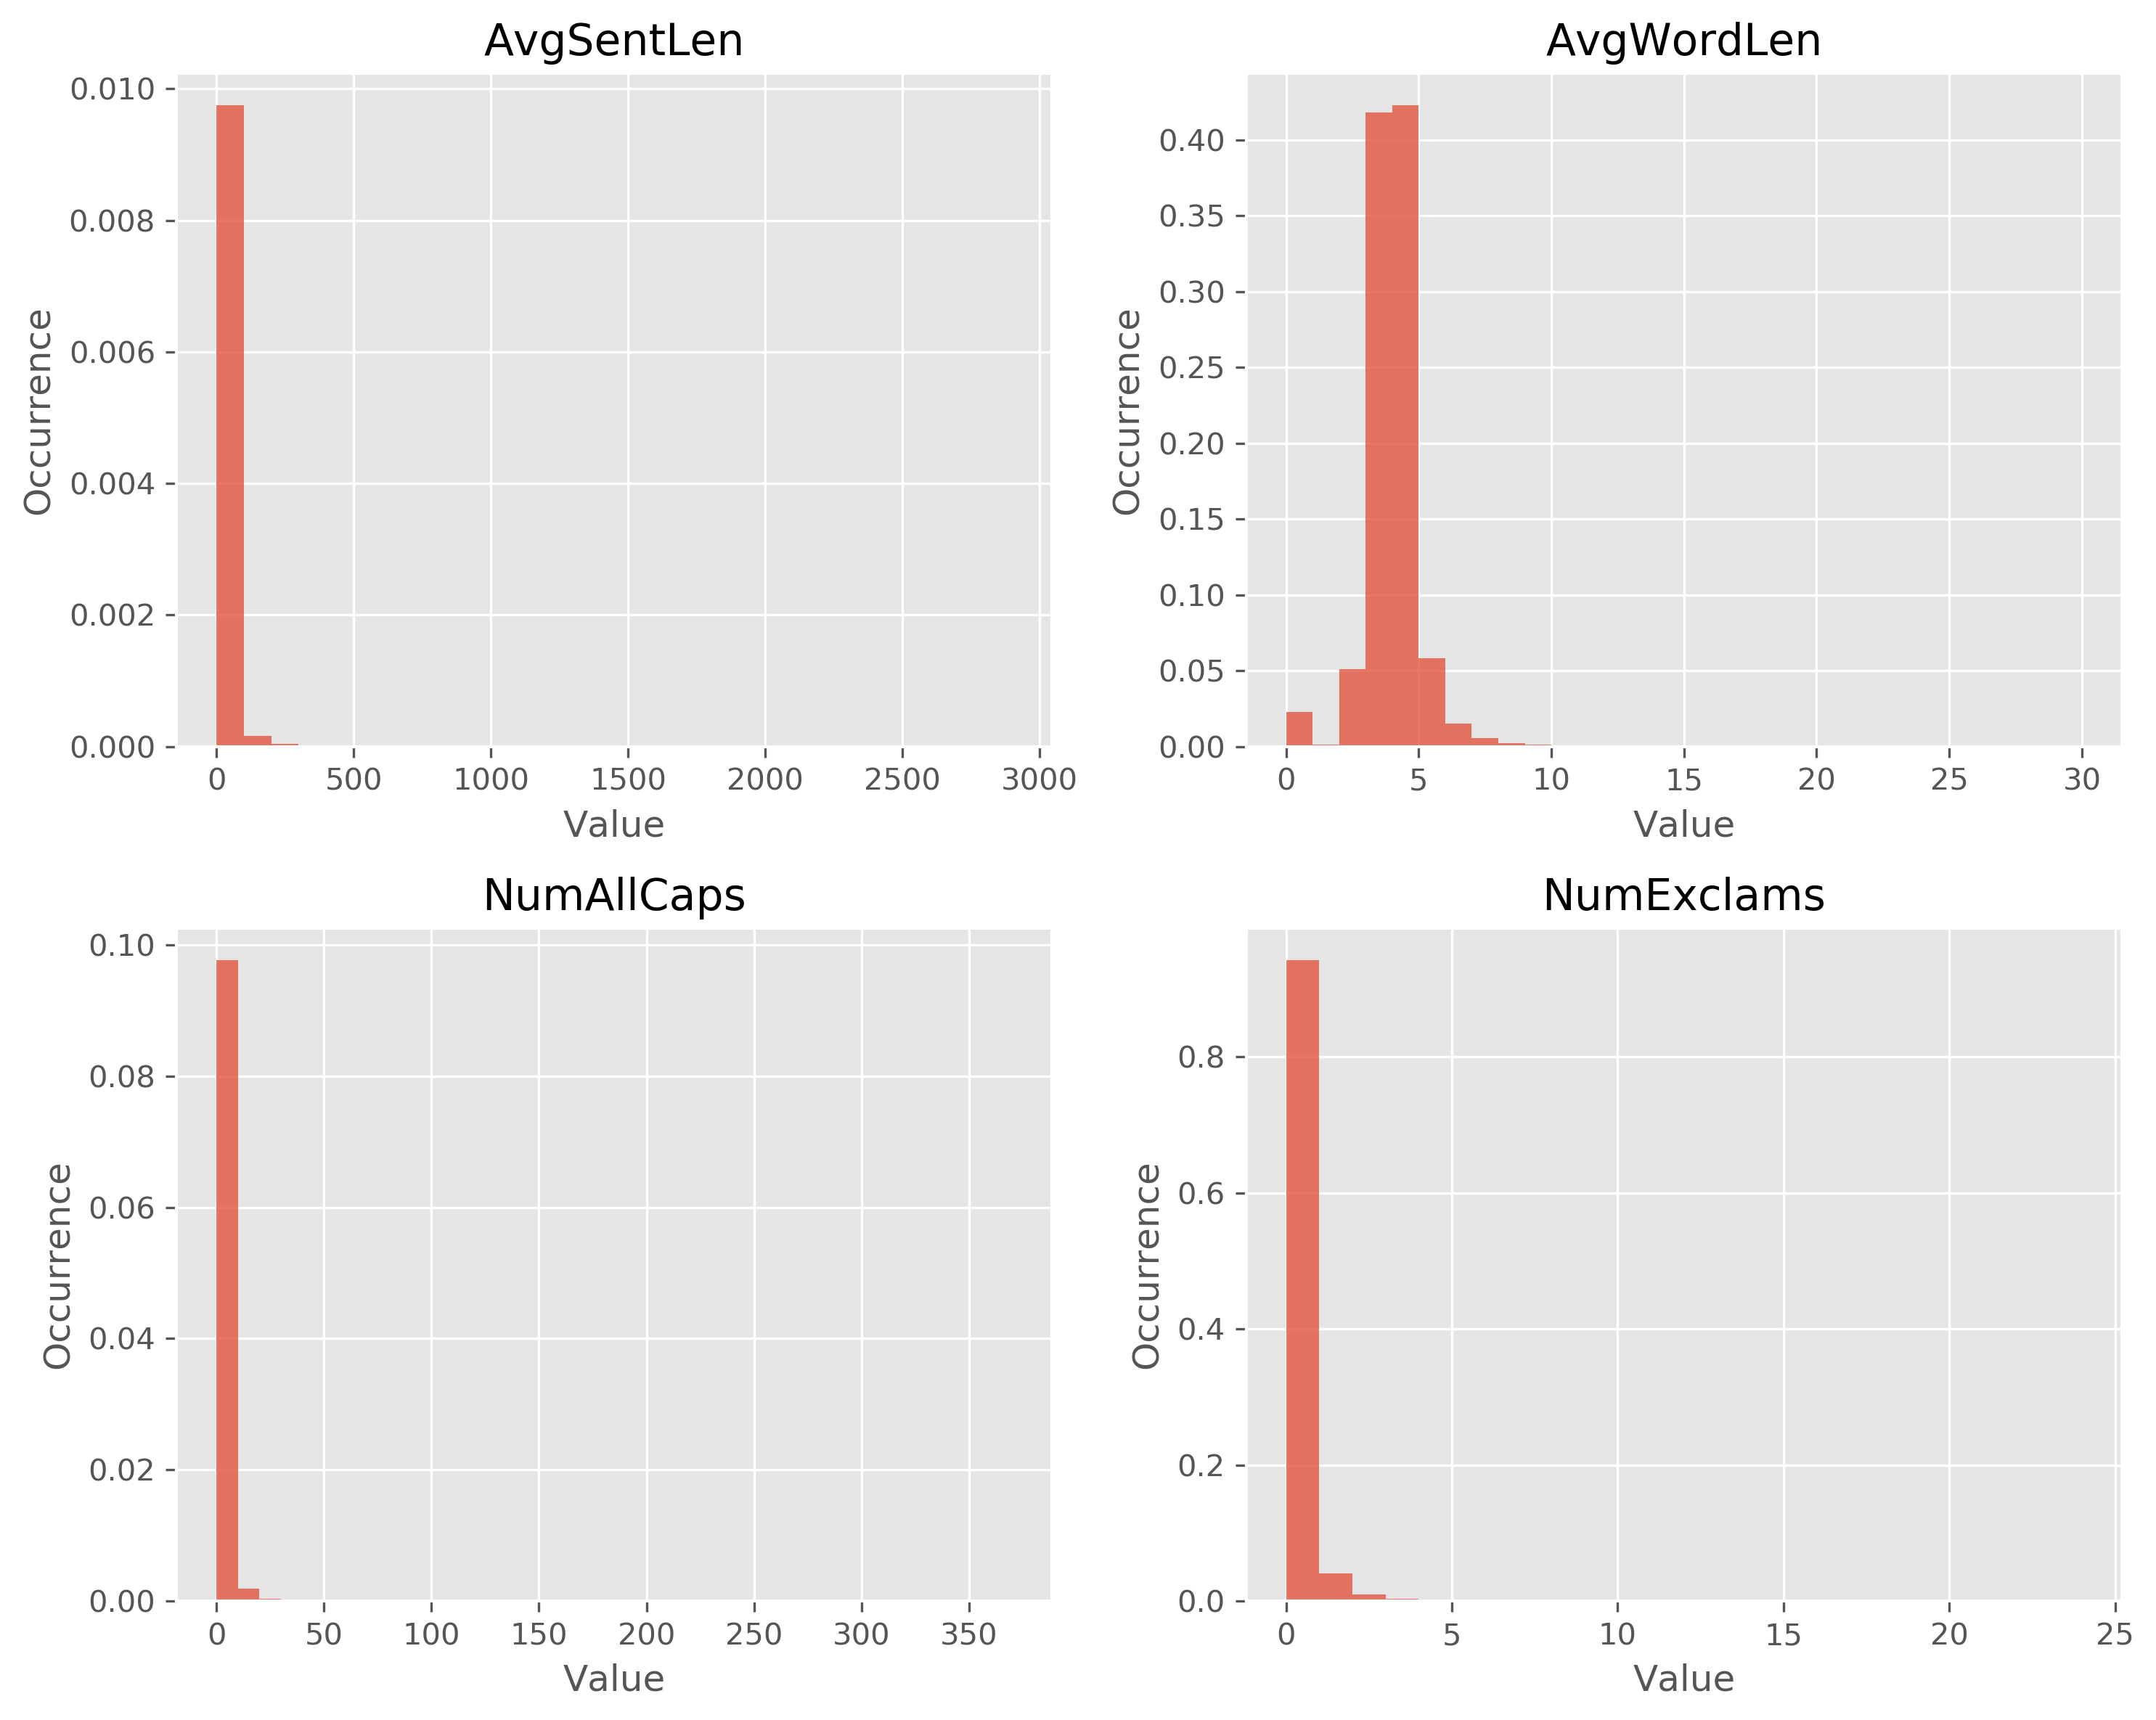

In [19]:
import nltk

def fetch_posts(fn):
    for line in open(fn, 'r', encoding='utf-8'):
        post_id, text = line.split('\t')
        yield int(post_id), text.strip()

def add_sentence_features(m):
    for pid, text in fetch_posts(fn_sample):
        if not text:
            for feat in ['AvgSentLen', 'AvgWordLen', 'NumAllCaps', 'NumExclams']:
                m[pid][feat] = 0
        else:
            sent_lens = [len(nltk.word_tokenize(sent)) for sent in nltk.sent_tokenize(text)]
            m[pid]['AvgSentLen'] = np.mean(sent_lens)
            text_tokens = nltk.word_tokenize(text)
            m[pid]['AvgWordLen'] = np.mean([len(w) for w in text_tokens])
            m[pid]['NumAllCaps'] = np.sum([word.isupper() for word in text_tokens])
            m[pid]['NumExclams'] = text.count('!')

add_sentence_features(meta)

plot_feat_hist([(np.asarray([[meta[aid][feat]] for aid in all_answers], dtype=int), feat) for feat in ['AvgSentLen', 'AvgWordLen', 'NumAllCaps', 'NumExclams']],
              '03_feat_hist_AvgSentLen_AvgWordLen_NumAllCaps_NumExclams');

In [20]:
X = np.asarray([get_features(aid, ['LinkCount', 'NumCodeLines', 'NumTextTokens', 
                                   'AvgSentLen', 'AvgWordLen', 'NumAllCaps', 
                                   'NumExclams']) for aid in all_answers], float)

scores = []
for train, test in tqdm(cv.split(X, Y), total=N_FOLDS):    
    clf = make_pipeline(StandardScaler(), KNeighborsClassifier())
    clf.fit(X[train], Y[train])
    scores.append(clf.score(X[test], Y[test]))

print("Mean(scores)=%.5f\tStddev(scores)=%.5f"%(np.mean(scores), np.std(scores))) 


Mean(scores)=0.60310	Stddev(scores)=0.01002


# High or low bias?

In [21]:
from sklearn.metrics import precision_recall_curve, roc_curve, auc, classification_report

def plot_bias_variance(data_sizes, train_errors, test_errors, name, title):
    plt.figure(num=None, figsize=(6, 5), dpi=300)
    plt.ylim([0.0, 1.0])
    plt.xlabel('Data set size')
    plt.ylabel('Error')
    plt.title("Bias-Variance for '%s'" % name)
    plt.plot(
        data_sizes, test_errors, "--", data_sizes, train_errors, "b-", lw=1)
    plt.legend(["test error", "train error"], loc="upper right")
    plt.grid(True)

def plot_pr(auc_score, name, precision, recall, label=None):
    plt.figure(num=None, figsize=(6, 5), dpi=300)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('P/R (AUC=%0.2f) / %s' % (auc_score, label))
    plt.fill_between(recall, precision, alpha=0.5)
    plt.grid(True)
    plt.plot(recall, precision, lw=1)
    filename = name.replace(" ", "_")+'_pr'
    save_png(filename)

def plot_feat_importance(feature_names, clf, name):
    plt.figure(num=None, figsize=(6, 5), dpi=300)
    coef_ = clf.coef_
    important = np.argsort(np.absolute(coef_.ravel()))
    f_imp = feature_names[important]
    coef = coef_.ravel()[important]
    inds = np.argsort(coef)
    f_imp = f_imp[inds]
    coef = coef[inds]
    xpos = np.array(list(range(len(coef))))
    plt.bar(xpos, coef, width=1, alpha=0.75)

    plt.title('Feature importance for %s' % (name.split('_')[-1]))
    ax = plt.gca()
    ax.set_xticks(np.arange(len(coef)))
    labels = ax.set_xticklabels(f_imp)
    for label in labels:
        label.set_rotation(90)
    filename = name.replace(" ", "_")+'_feat_imp'
    save_png(filename)

def measure(clf_class, parameters, name, X, Y, data_size=None, plot=None, feature_names=None):
    if data_size is not None:
        X = X[:data_size]
        Y = Y[:data_size]

    train_errors = []
    test_errors = []

    scores = []
    roc_scores = []
    fprs, tprs = [], []

    pr_scores = []
    precisions, recalls, thresholds = [], [], []

    for fold_idx, (train, test) in enumerate(cv.split(X, Y)):
        X_train, y_train = X[train], Y[train]
        X_test, y_test = X[test], Y[test]

        only_one_class_in_train = len(set(y_train)) == 1
        only_one_class_in_test = len(set(y_test)) == 1
        if only_one_class_in_train or only_one_class_in_test:
            # this would pose problems later on
            continue

        clf = clf_class(**parameters)

        clf.fit(X_train, y_train)

        train_score = clf.score(X_train, y_train)
        test_score = clf.score(X_test, y_test)

        train_errors.append(1 - train_score)
        test_errors.append(1 - test_score)

        scores.append(test_score)
        proba = clf.predict_proba(X_test)

        label_idx = 1
        fpr, tpr, roc_thresholds = roc_curve(y_test, proba[:, label_idx])
        precision, recall, pr_thresholds = precision_recall_curve(y_test, proba[:, label_idx])

        roc_scores.append(auc(fpr, tpr))
        fprs.append(fpr)
        tprs.append(tpr)

        pr_scores.append(auc(recall, precision))
        precisions.append(precision)
        recalls.append(recall)
        thresholds.append(pr_thresholds)

        # This threshold is determined at the end of the chapter,
        # where we find conditions such that precision is in the area of
        # about 80%. With it we trade off recall for precision.
        threshold_for_detecting_good_answers = 0.59

        if False:
            print("Clone #%i" % fold_idx)
            print(classification_report(y_test, proba[:, label_idx] >
                  threshold_for_detecting_good_answers, target_names=['not accepted', 'accepted']))

    # get medium clone
    scores_to_sort = pr_scores  # roc_scores
    medium = np.argsort(scores_to_sort)[len(scores_to_sort) // 2]
    # print("Medium clone is #%i" % medium)

    if plot:
        #plot_roc(roc_scores[medium], name, fprs[medium], tprs[medium])
        plot_pr(pr_scores[medium], name, precisions[medium],
                recalls[medium], plot + " answers")

        if hasattr(clf, 'coef_'):
            plot_feat_importance(feature_names, clf, name)
        elif hasattr(clf, 'named_steps'):
            for step, s_clf in clf.named_steps.items():
                if hasattr(s_clf, 'coef_'):
                    plot_feat_importance(feature_names, s_clf, name)

    summary = {'name': name,
               'scores': scores,
               'roc_scores': roc_scores,
               'pr_scores': pr_scores,
               'med_precisions': precisions[medium], 
               'med_recalls': recalls[medium], 
               'med_thresholds': thresholds[medium]}
    
    return np.mean(train_errors), np.mean(test_errors), summary

def bias_variance_analysis(clf_class, parameters, name, X, Y):
    data_sizes = np.arange(40, 2000, 20)

    train_errors = []
    test_errors = []

    for data_size in data_sizes:
        train_error, test_error, _ = measure(clf_class, parameters, name, X, Y, data_size=data_size)
        train_errors.append(train_error)
        test_errors.append(test_error)

    plot_bias_variance(data_sizes, train_errors,
                       test_errors, name, "Bias-Variance for '%s'" % name)

As we have learned in the previous chapter, when using features with different value ranges, it helps to standardize them.

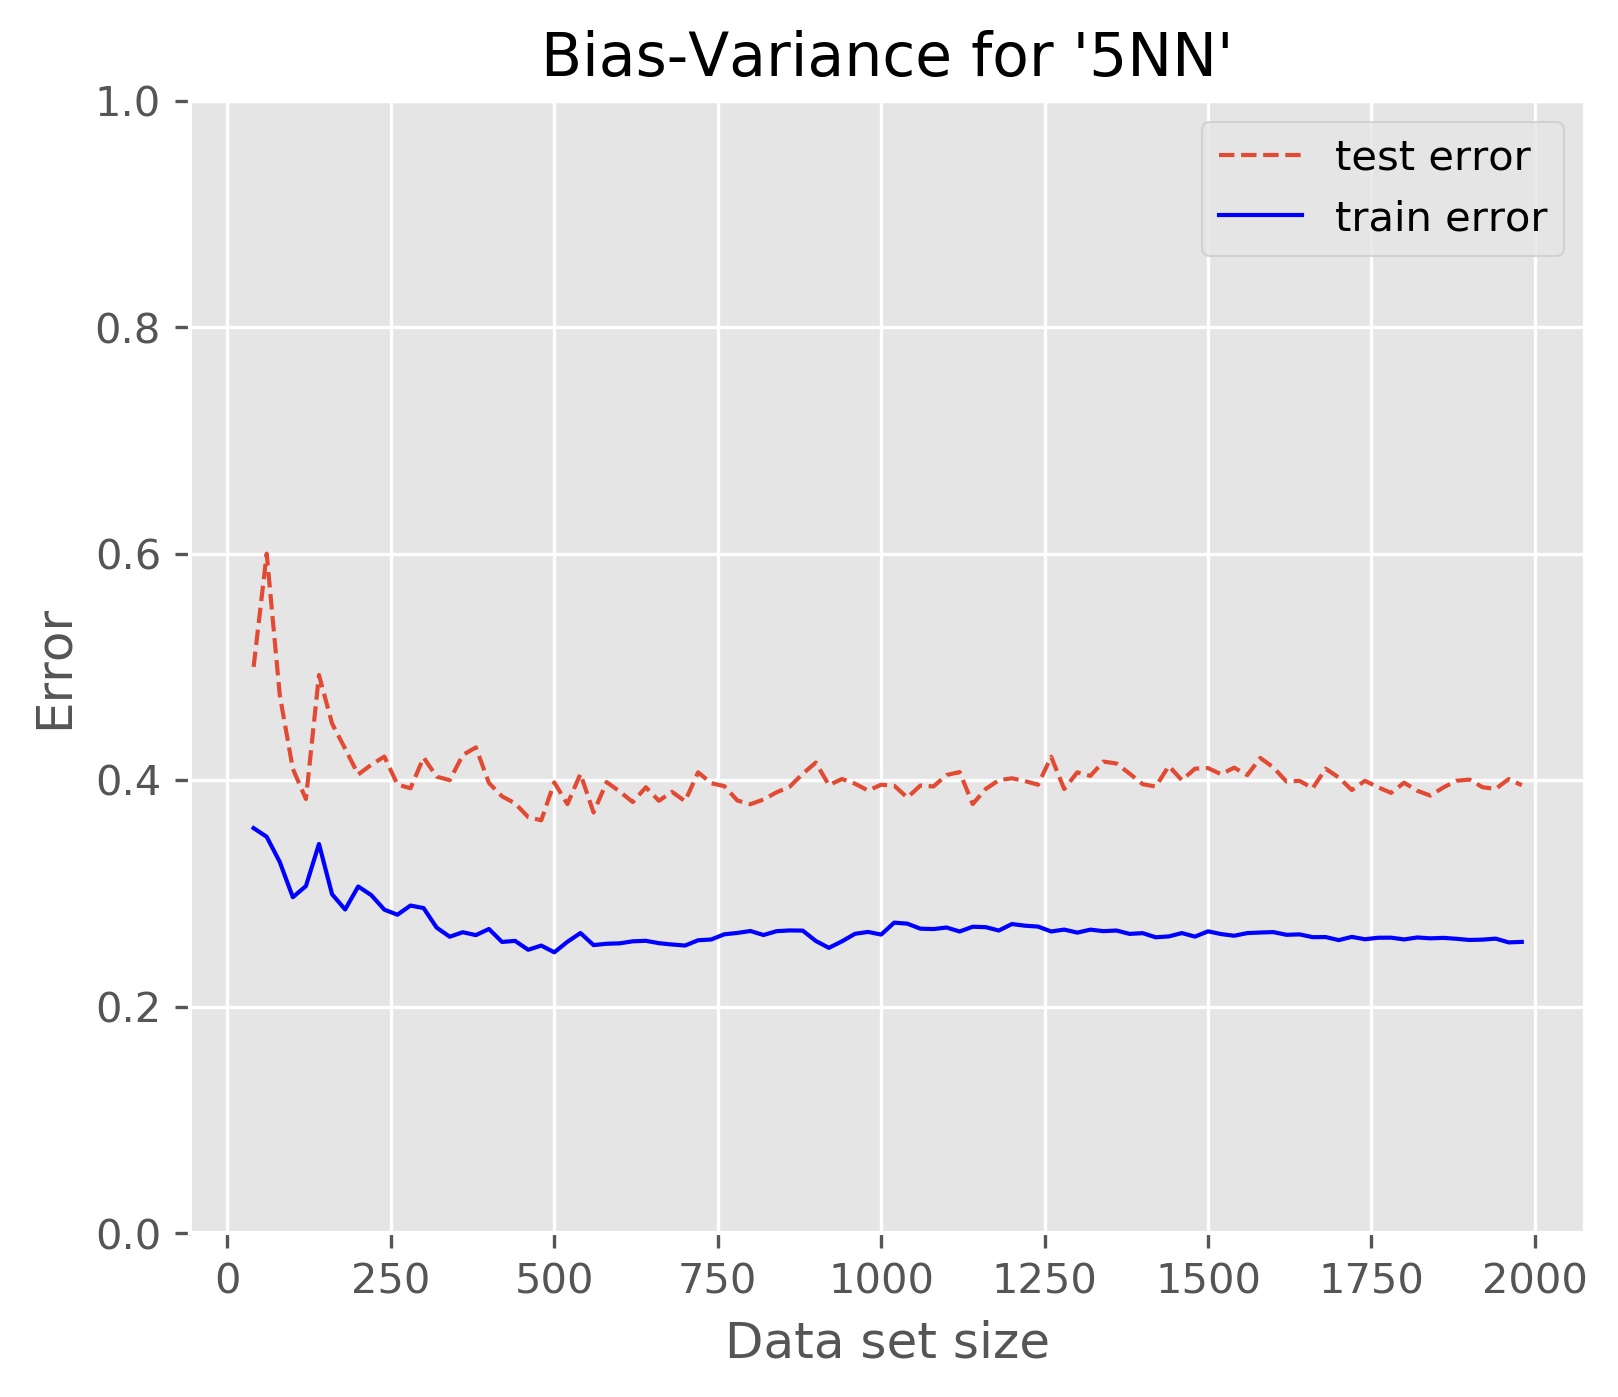

In [22]:
def create_pipeline(**param):
    return make_pipeline(StandardScaler(), KNeighborsClassifier(**param))

bias_variance_analysis(create_pipeline, {'n_neighbors': 5}, "5NN", X, Y)
save_png('04_bv_5NN_all')

Maybe simplifying the feature space helps. Let's try out to use only `LinkCount` and `NumTextTokens`:

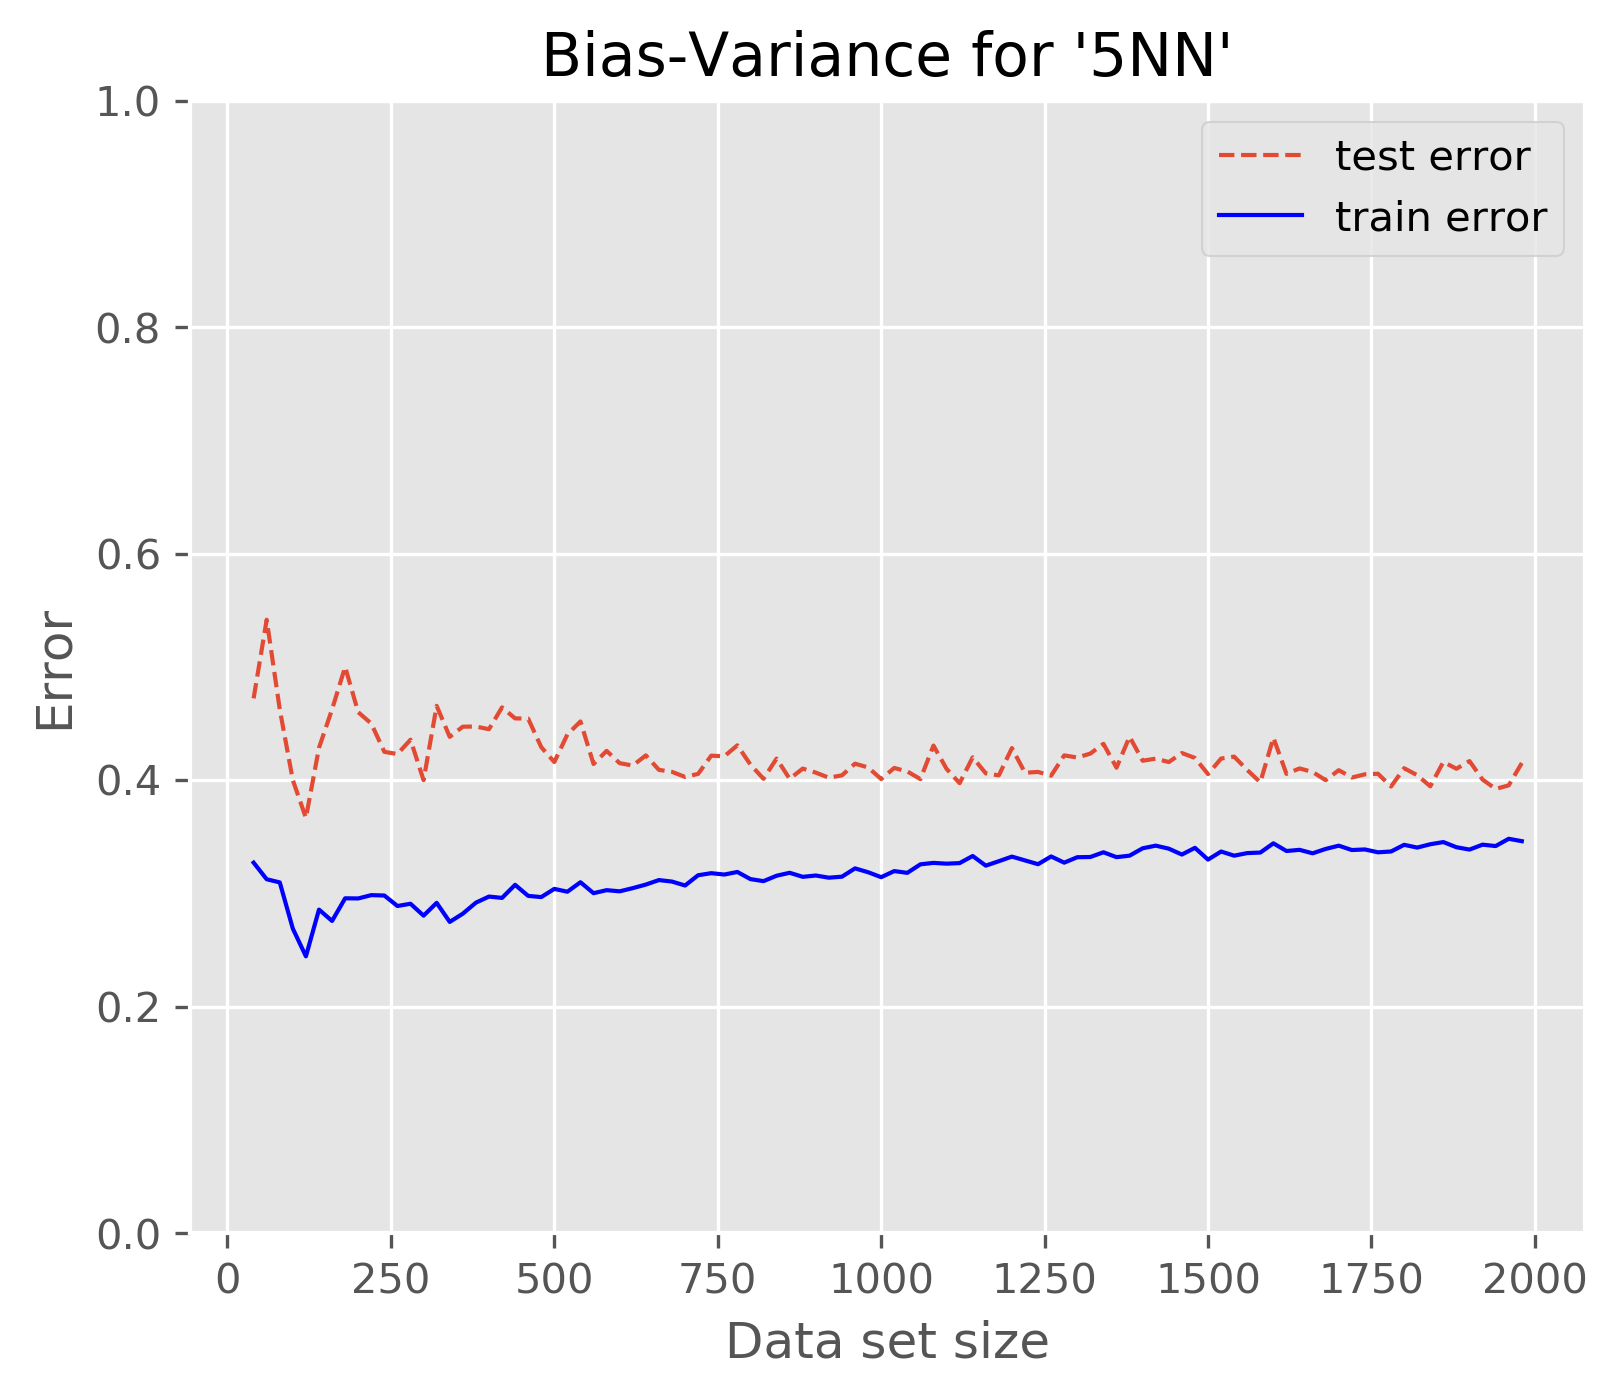

In [23]:
from sklearn.utils import shuffle
X_simp = np.asarray([get_features(aid, ['LinkCount', 'NumTextTokens']) for aid in all_answers], float)
X_simp, Y_simp = shuffle(X_simp, Y, random_state=0)

bias_variance_analysis(create_pipeline, {'n_neighbors': 5}, "5NN", X_simp, Y_simp)
save_png('05_bv_5NN_simp')

Does it help to reduce the model complexity by increasing $k$?

In [24]:
print('k\tmean(scores)\tstddev(scores)')
for k in [5, 10, 40]:
    _, _, summary = measure(create_pipeline, {'n_neighbors': k}, "%iNN" % k, X, Y)
    print('%d\t%.4f\t\t%.4f' % (k, np.mean(summary['scores']), np.std(summary['scores'])))

k	mean(scores)	stddev(scores)
5	0.6031		0.0100
10	0.6190		0.0113
40	0.6413		0.0110


It helps a bit, but do we really want to compare with 40 different samples each time?

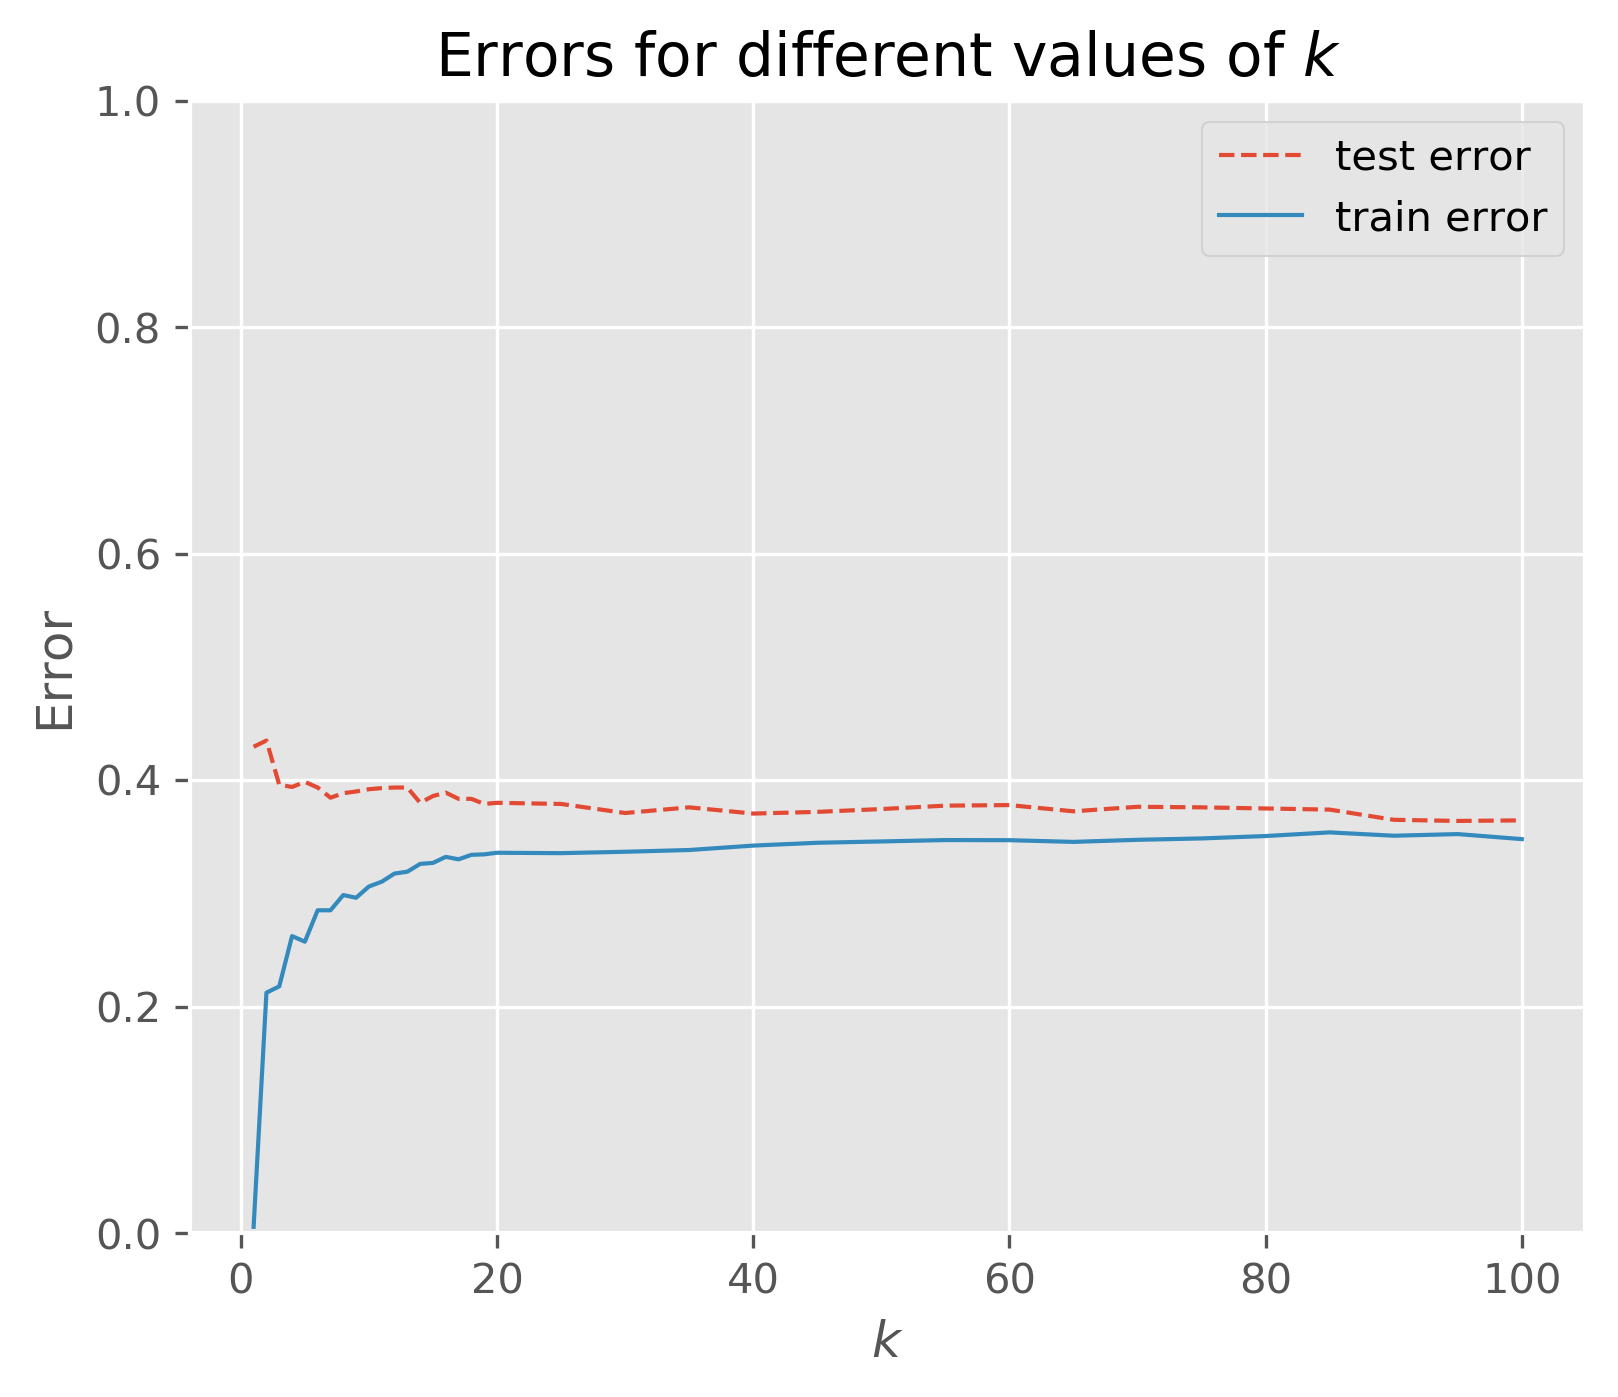

In [25]:
def plot_k_complexity(ks, train_errors, test_errors):
    plt.figure(num=None, figsize=(6, 5), dpi=300)
    plt.ylim([0.0, 1.0])
    plt.xlabel('$k$')
    plt.ylabel('Error')
    plt.title('Errors for different values of $k$')
    plt.plot(ks, test_errors, "--", ks, train_errors, "-", lw=1)
    plt.legend(["test error", "train error"], loc="upper right")
    plt.grid(True)
    save_png('06_kcomplexity')

def k_complexity_analysis(clf_class, X, Y):
    # Measure for different k's: [1,2,..,20,25,..,100]
    ks = np.hstack((np.arange(1, 21), np.arange(25, 101, 5)))
    
    train_errors = []
    test_errors = []

    for k in ks:
        train_error, test_error, _ = measure(clf_class, {'n_neighbors': k}, "%dNN" % k, X, Y, data_size=2000)
        train_errors.append(train_error)
        test_errors.append(test_error)

    plot_k_complexity(ks, train_errors, test_errors)


k_complexity_analysis(create_pipeline, X, Y)    

And we won't get much better with increasing values of $k$.

# Using logistic regression
Creating some toy data to visualize how logistic regression works...

In [27]:
from scipy.stats import norm

np.random.seed(3)

NUM_PER_CLASS = 40
X_log = np.hstack((norm.rvs(2, size=NUM_PER_CLASS, scale=2), norm.rvs(8, size=NUM_PER_CLASS, scale=3)))
y_log = np.hstack((np.zeros(NUM_PER_CLASS), np.ones(NUM_PER_CLASS))).astype(int)
print(X_log)
print(y_log)

[ 5.57725695  2.8730197   2.19299494 -1.72698541  1.44522359  1.29048204
  1.83451704  0.74599865  1.91236366  1.04556394 -0.62772951  3.76924476
  3.76263608  5.41914613  2.10006728  1.19064517  0.9092801  -1.09295463
  3.96473487 -0.20213526 -0.37009305  1.5887002   4.97229671  2.47343253
 -0.04757028  0.5740136   3.25048993  1.67897327  0.4623273   1.53993856
  3.49011253  5.95222157 -0.48824666  0.74716618  0.39246781 -2.83816635
  0.15241596 -0.04775152  4.24795592  1.73617153  3.13014366  9.94002636
  6.93118772  2.77057689  6.21005107  6.23421686  5.37835311  8.08914145
  1.2552267   7.19671441 11.03955033 10.55839352 11.3245625  11.35817197
 12.4626294   4.64509795 10.53750022  2.41733141  6.19134469  2.25658387
 11.14444254 12.00121346  7.40775596 13.32393509  5.97581747  8.4518506
  8.45883711  4.80741418  9.31383983 13.81693538  4.92520738 10.69801534
  7.53647944 13.30888191  9.45136504 10.0286492   9.92948984  8.74726012
  3.81270949 12.17498872]
[0 0 0 0 0 0 0 0 0 0 0 0 0

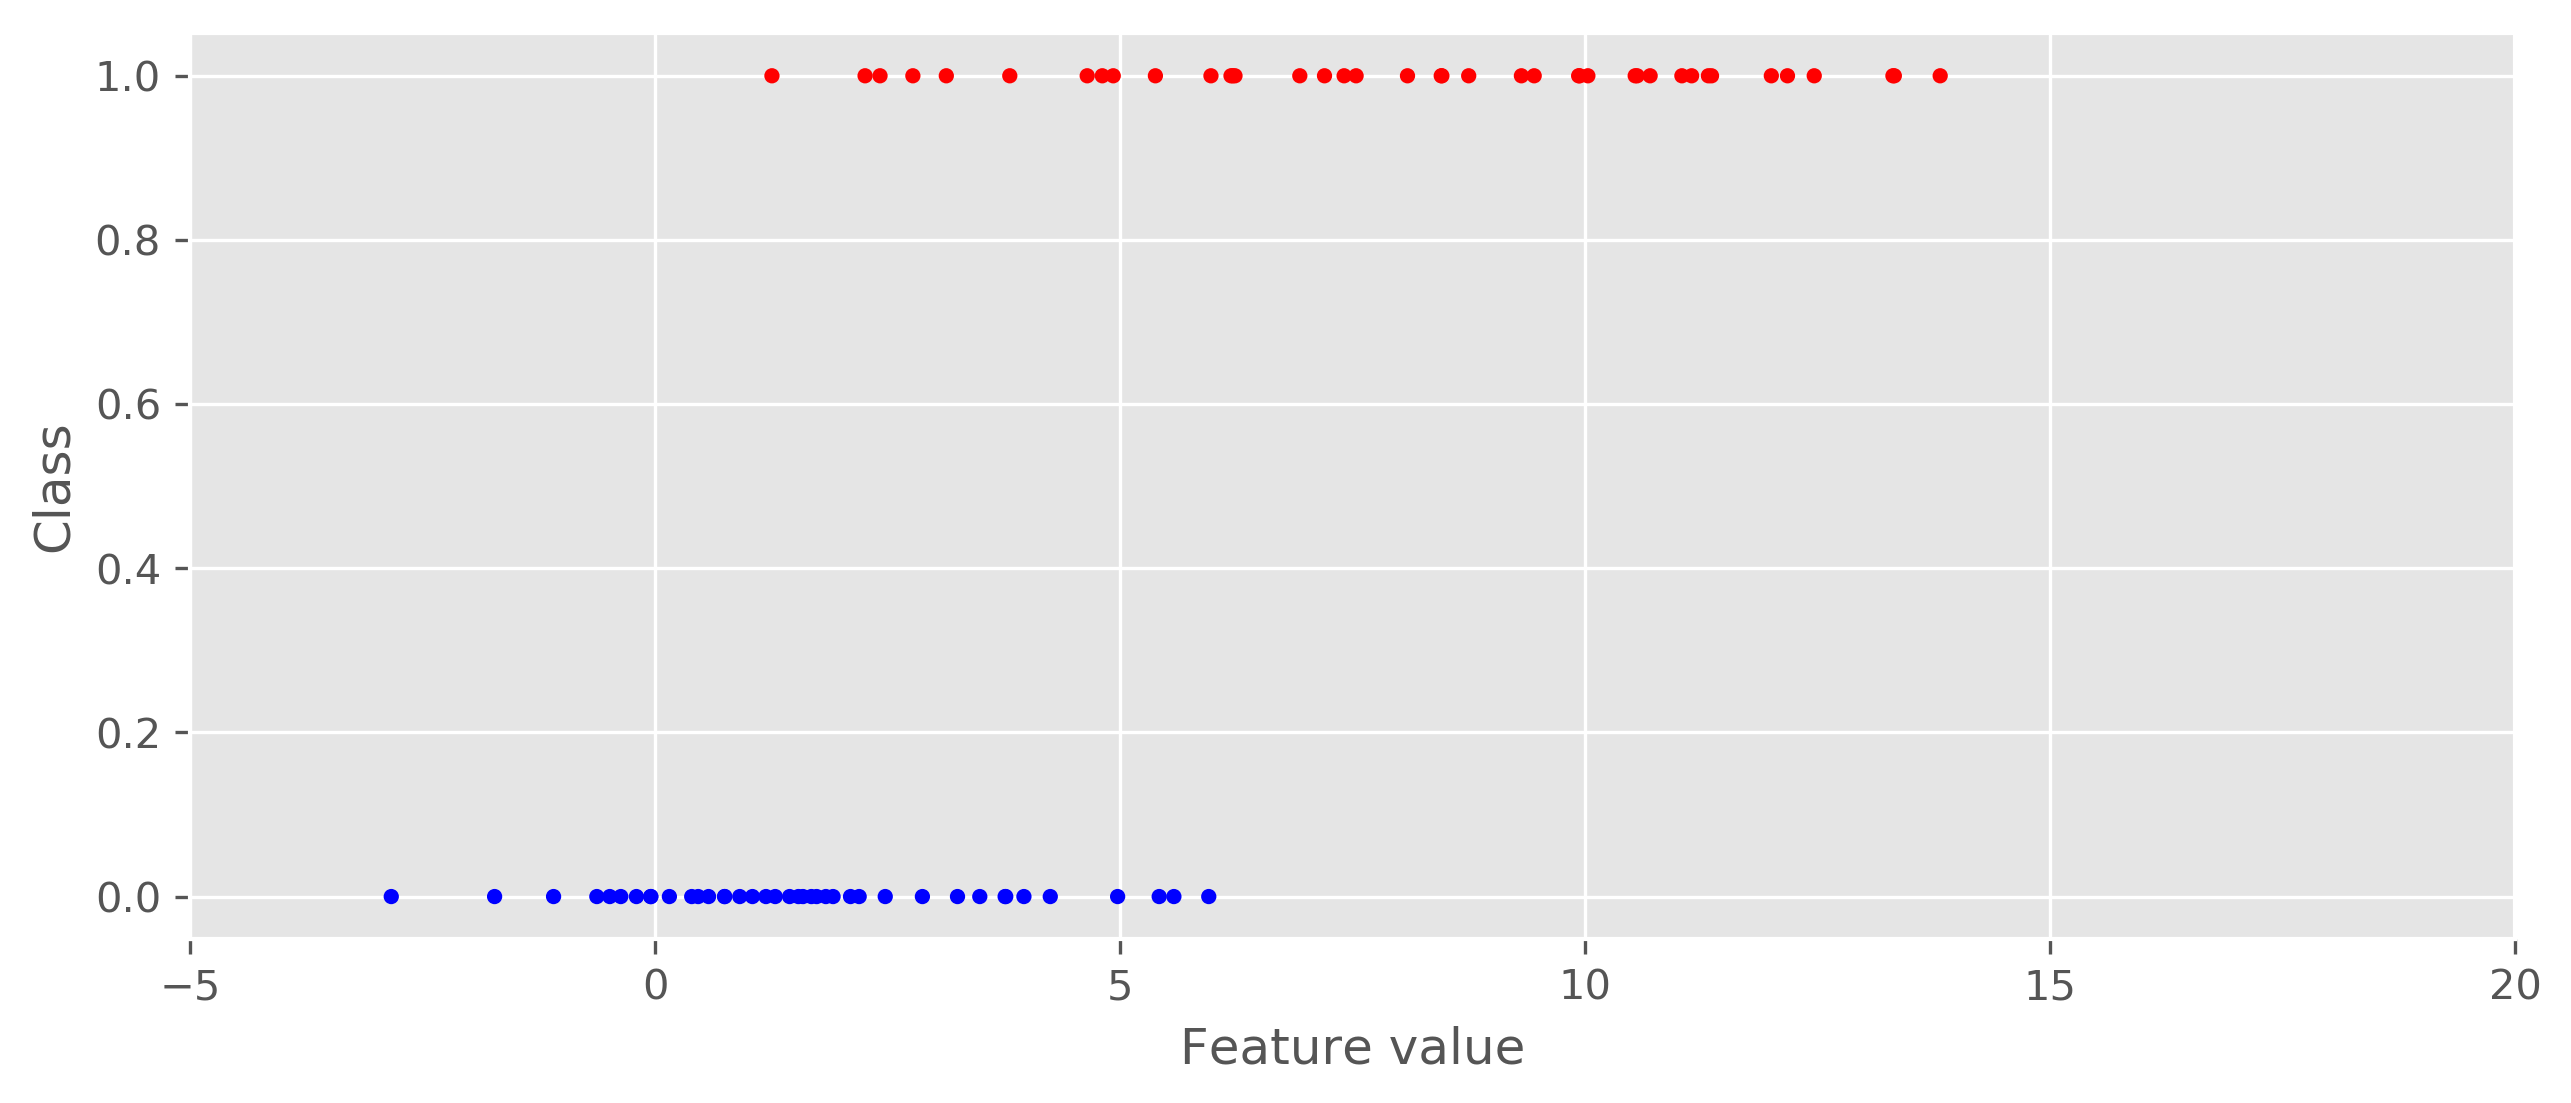

In [29]:
plt.figure(figsize=(10, 4), dpi=300)
plt.grid(True)

plt.xlim((-5, 20))
plt.scatter(X_log, y_log, c=np.array(['blue', 'red'])[y_log], s=10)
plt.xlabel("Feature value")
plt.ylabel("Class")
save_png('06_log_reg_example_data')

In [30]:
from sklearn.linear_model import LogisticRegression

def lr_model(clf, X):
    '''
    https://en.wikipedia.org/wiki/Logistic_regression
    '''
    return 1.0 / (1.0 + np.exp(-(clf.intercept_ + clf.coef_ * X)))

logclf = LogisticRegression()
logclf.fit(X_log.reshape(NUM_PER_CLASS * 2, 1), y_log)
print(np.exp(logclf.intercept_), np.exp(logclf.coef_.ravel()))
print("P(x=-1)=%.2f\tP(x=7)=%.2f" %(lr_model(logclf, -1), lr_model(logclf, 7)))

C:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[0.09437188] [1.80094112]
P(x=-1)=0.05	P(x=7)=0.85


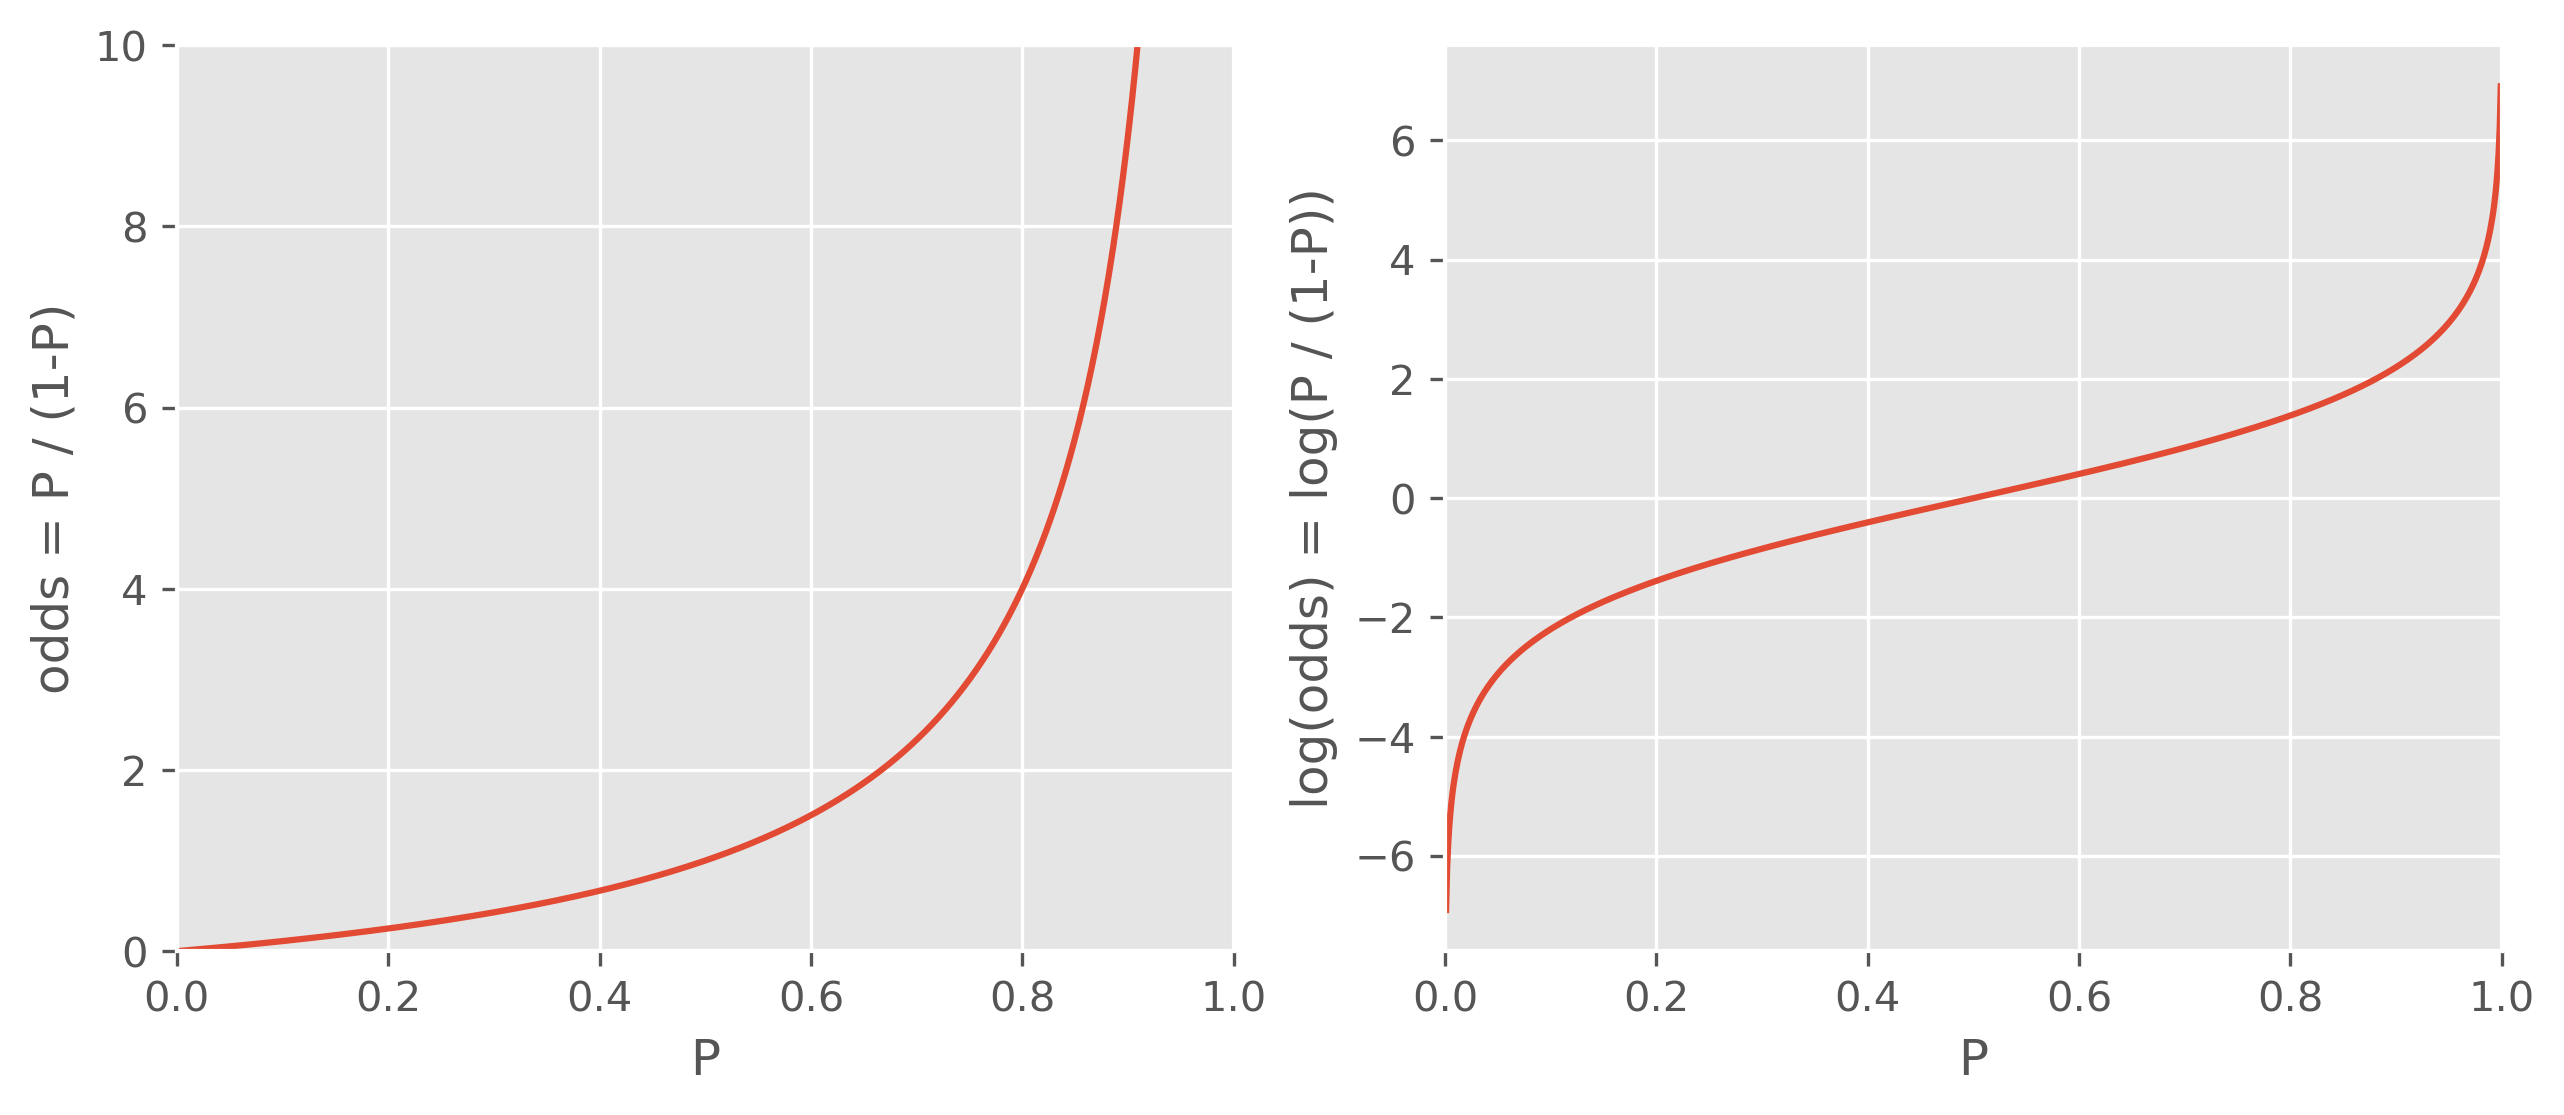

In [31]:
X_odds = np.arange(0.001, 1, 0.001)
plt.figure(figsize=(10, 4), dpi=300)
plt.subplot(1, 2, 1)
plt.xlim((0, 1))
plt.ylim((0, 10))
plt.plot(X_odds, X_odds / (1 - X_odds))
plt.xlabel("P")
plt.ylabel("odds = P / (1-P)")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.xlim((0, 1))
plt.plot(X_odds, np.log(X_odds / (1 - X_odds)))
plt.xlabel("P")
plt.ylabel("log(odds) = log(P / (1-P))")
plt.grid(True)
save_png('07_log_reg_log_odds')

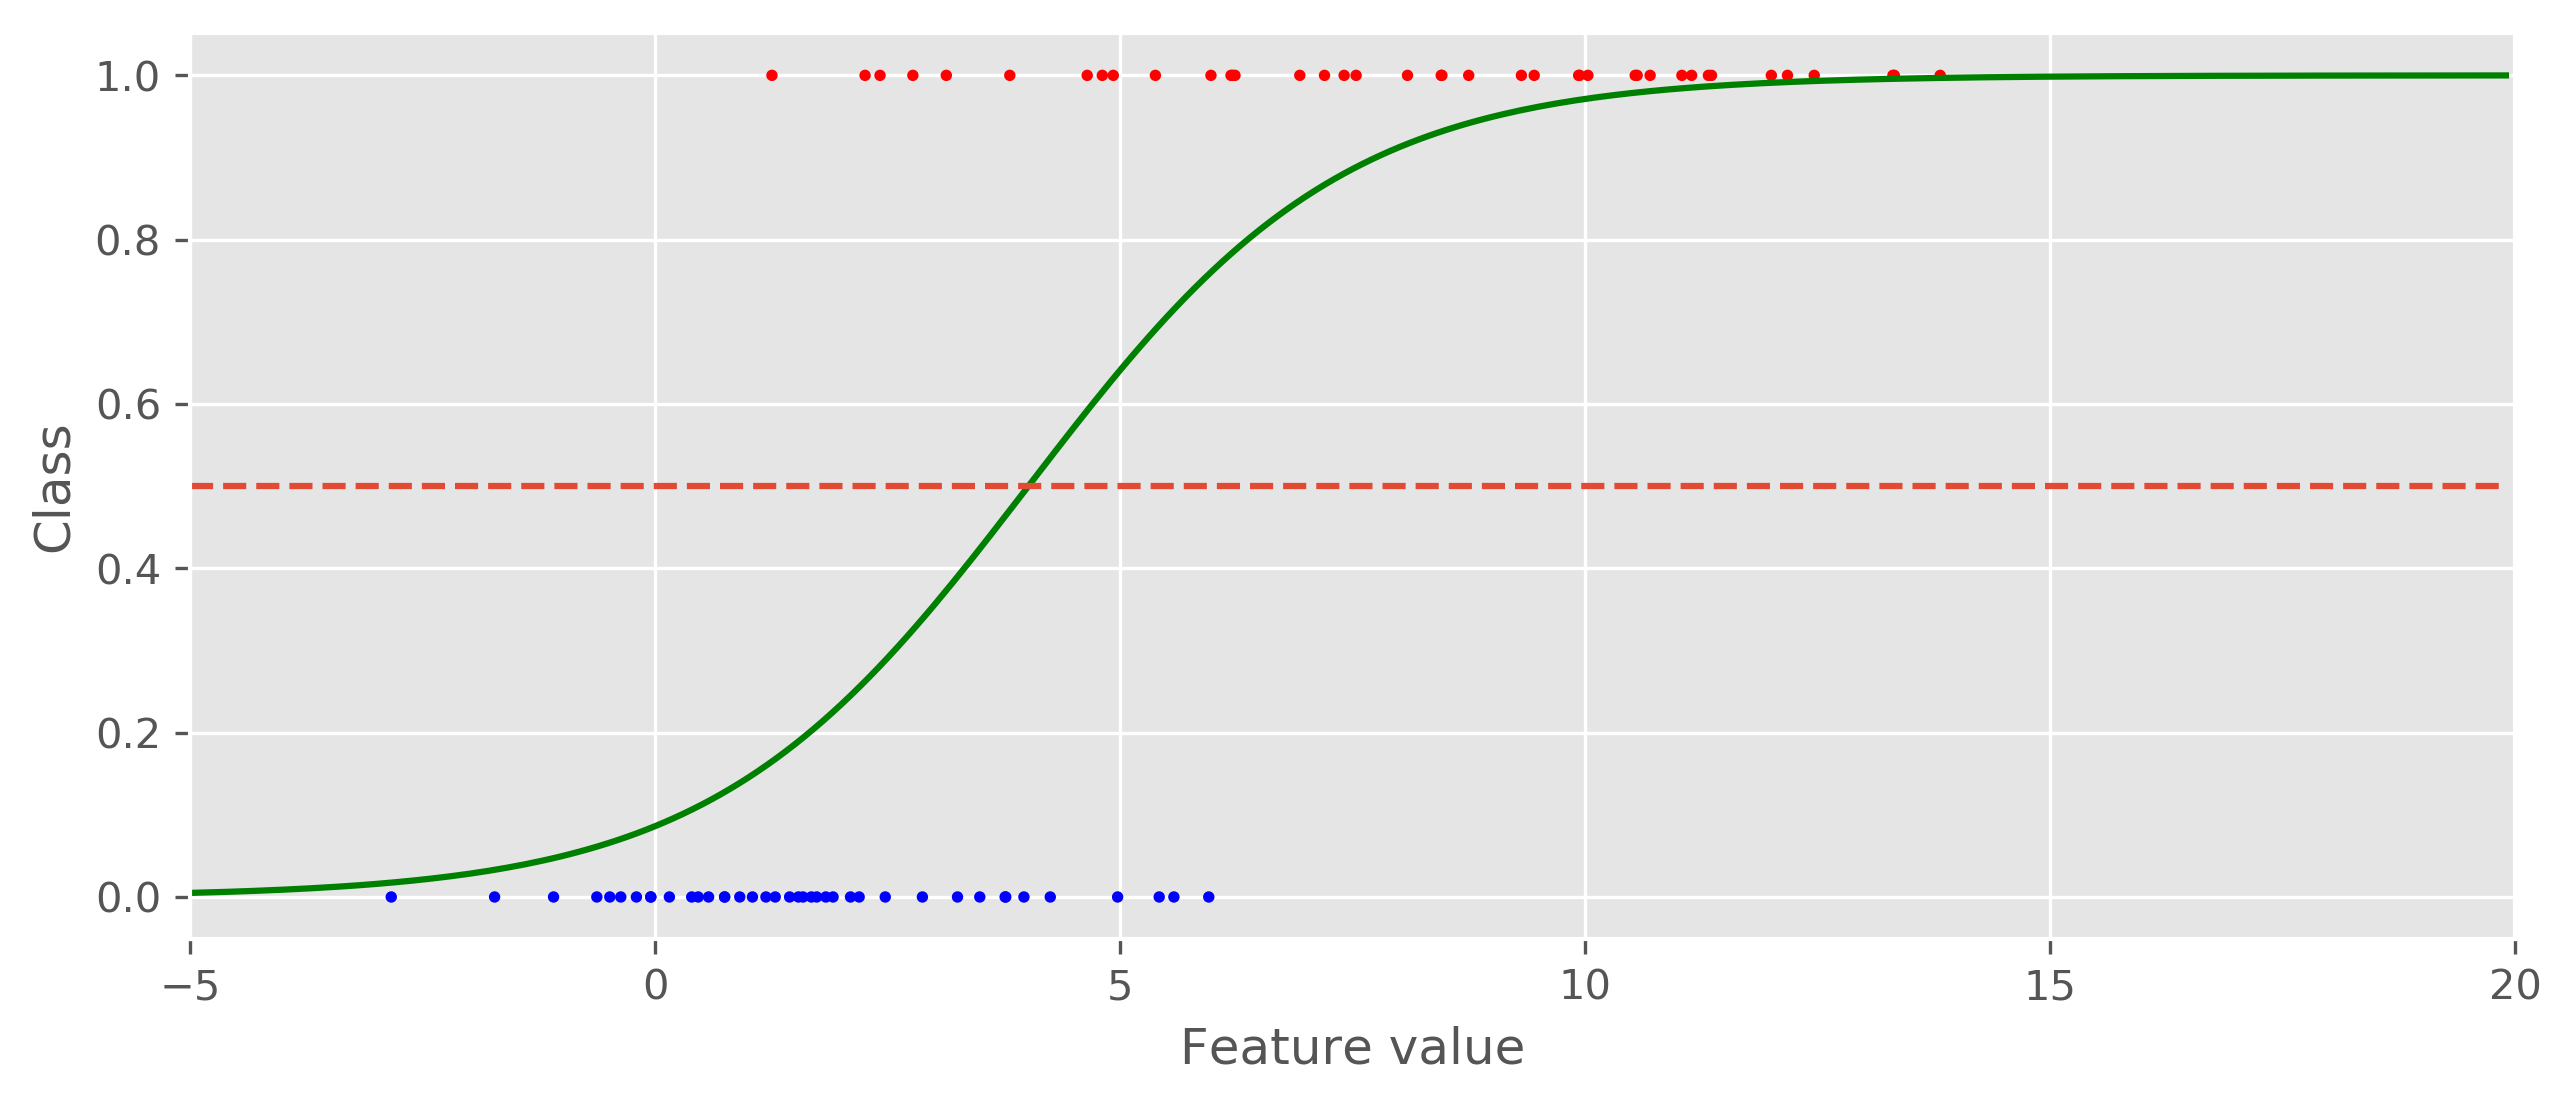

In [32]:
X_range = np.arange(-5, 20, 0.1)

plt.figure(figsize=(10, 4), dpi=300)
plt.xlim((-5, 20))
plt.scatter(X_log, y_log, c=np.array(['blue', 'red'])[y_log], s=5)
plt.plot(X_range, lr_model(logclf, X_range).ravel(), c='green')
plt.plot(X_range, np.ones(X_range.shape[0]) * 0.5, "--")
plt.xlabel("Feature value")
plt.ylabel("Class")
plt.grid(True)
save_png('08_log_reg_example_fitted')

# Applying logistic regression to our post classification problem

In [33]:
print('C\tmean(scores)\tstddev(scores)') 
for C in [0.001, 0.01, 0.1, 1.0, 10.0]:
    name = "LogReg C=%.2f" % C
    _, _, summary = measure(LogisticRegression, {'C': C}, name, X, Y)

    print('%7.3f\t%.4f\t\t%.4f' % (C, np.mean(summary['scores']), np.std(summary['scores'])))

C	mean(scores)	stddev(scores)


C:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Anaconda3\lib\site-packages

  0.001	0.6395		0.0089


C:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Anaconda3\lib\site-packages

  0.010	0.6419		0.0093


C:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Anaconda3\lib\site-packages

  0.100	0.6395		0.0092


C:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Anaconda3\lib\site-packages

  1.000	0.6396		0.0093


C:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Anaconda3\lib\site-packages

 10.000	0.6393		0.0092


In [34]:
C_best = 0.01

# Looking behind accuracy – precision and recall 

C:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Anaconda3\lib\site-packages

C:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Anaconda3\lib\site-packages

C:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Anaconda3\lib\site-packages

C:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Anaconda3\lib\site-packages

C:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Anaconda3\lib\site-packages

C:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Anaconda3\lib\site-packages

C:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Anaconda3\lib\site-packages

C:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Anaconda3\lib\site-packages

C:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Anaconda3\lib\site-packages

C:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Anaconda3\lib\site-packages

C:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Anaconda3\lib\site-packages

C:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Anaconda3\lib\site-packages

C:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Anaconda3\lib\site-packages

C:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Anaconda3\lib\site-packages

C:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Anaconda3\lib\site-packages

C:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Anaconda3\lib\site-packages

C:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Anaconda3\lib\site-packages

C:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Anaconda3\lib\site-packages

C:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Anaconda3\lib\site-packages

C:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Anaconda3\lib\site-packages

C:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Anaconda3\lib\site-packages

C:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Anaconda3\lib\site-packages

C:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Anaconda3\lib\site-packages

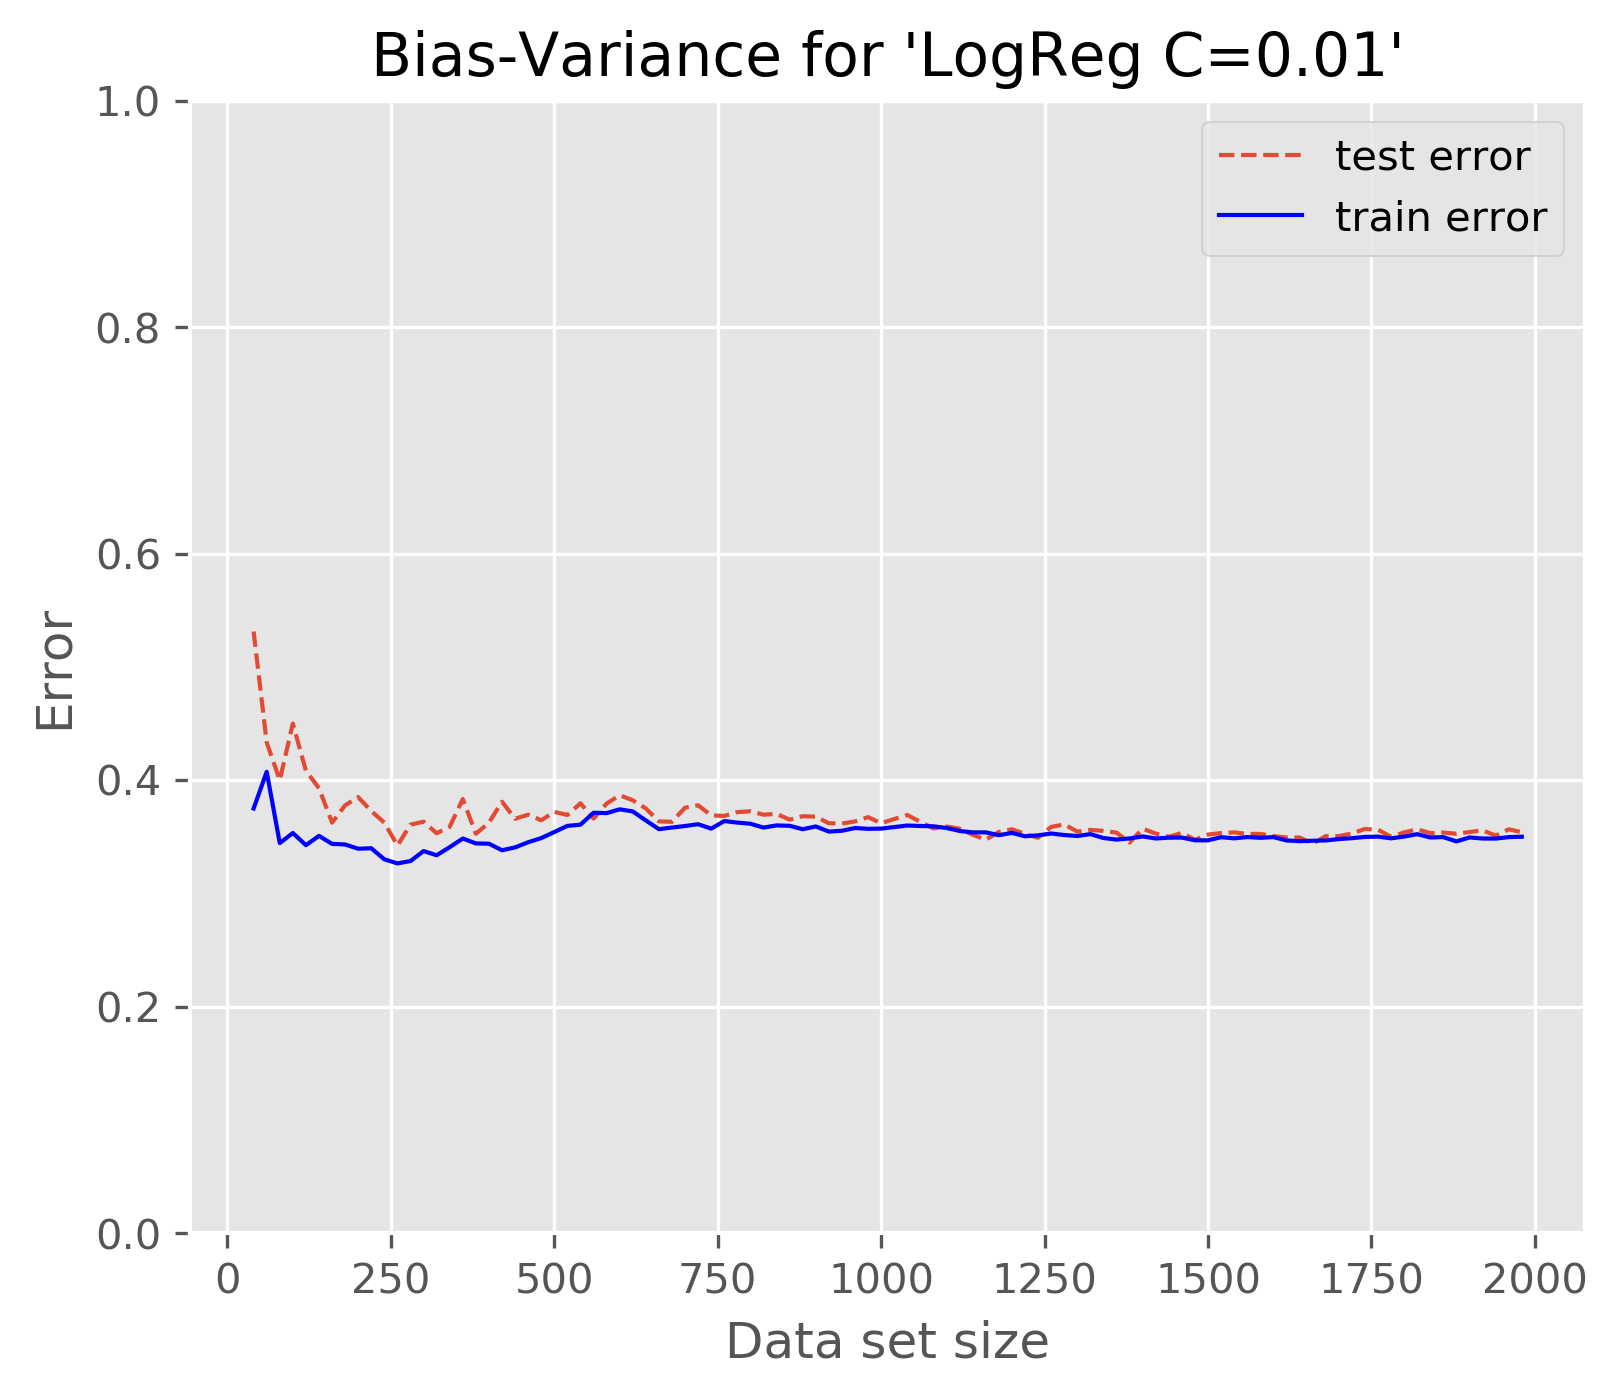

In [35]:
bias_variance_analysis(LogisticRegression, {'C': C_best}, "LogReg C=0.01", X, Y)
save_png('09_bv_LogReg')

Good answers...


C:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Anaconda3\lib\site-packages

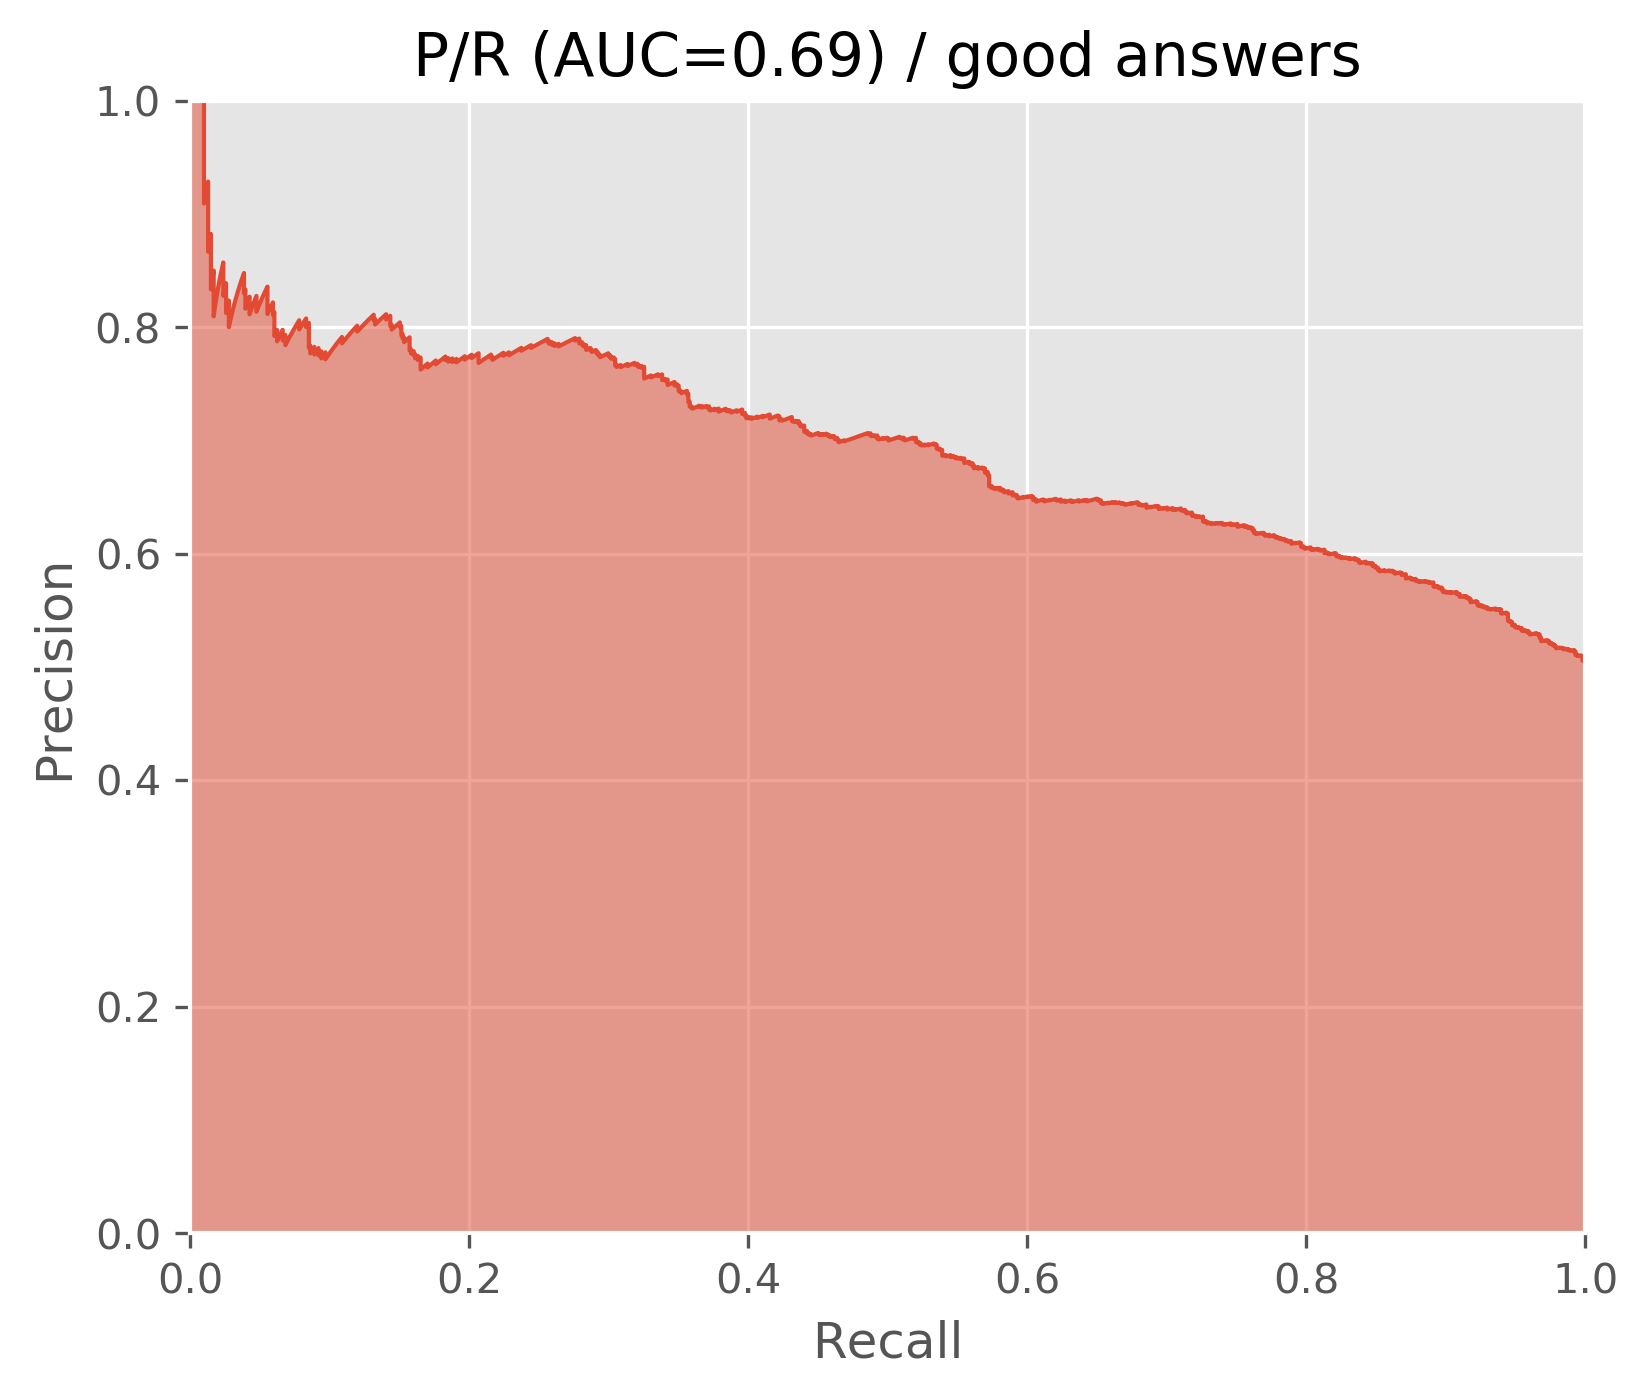

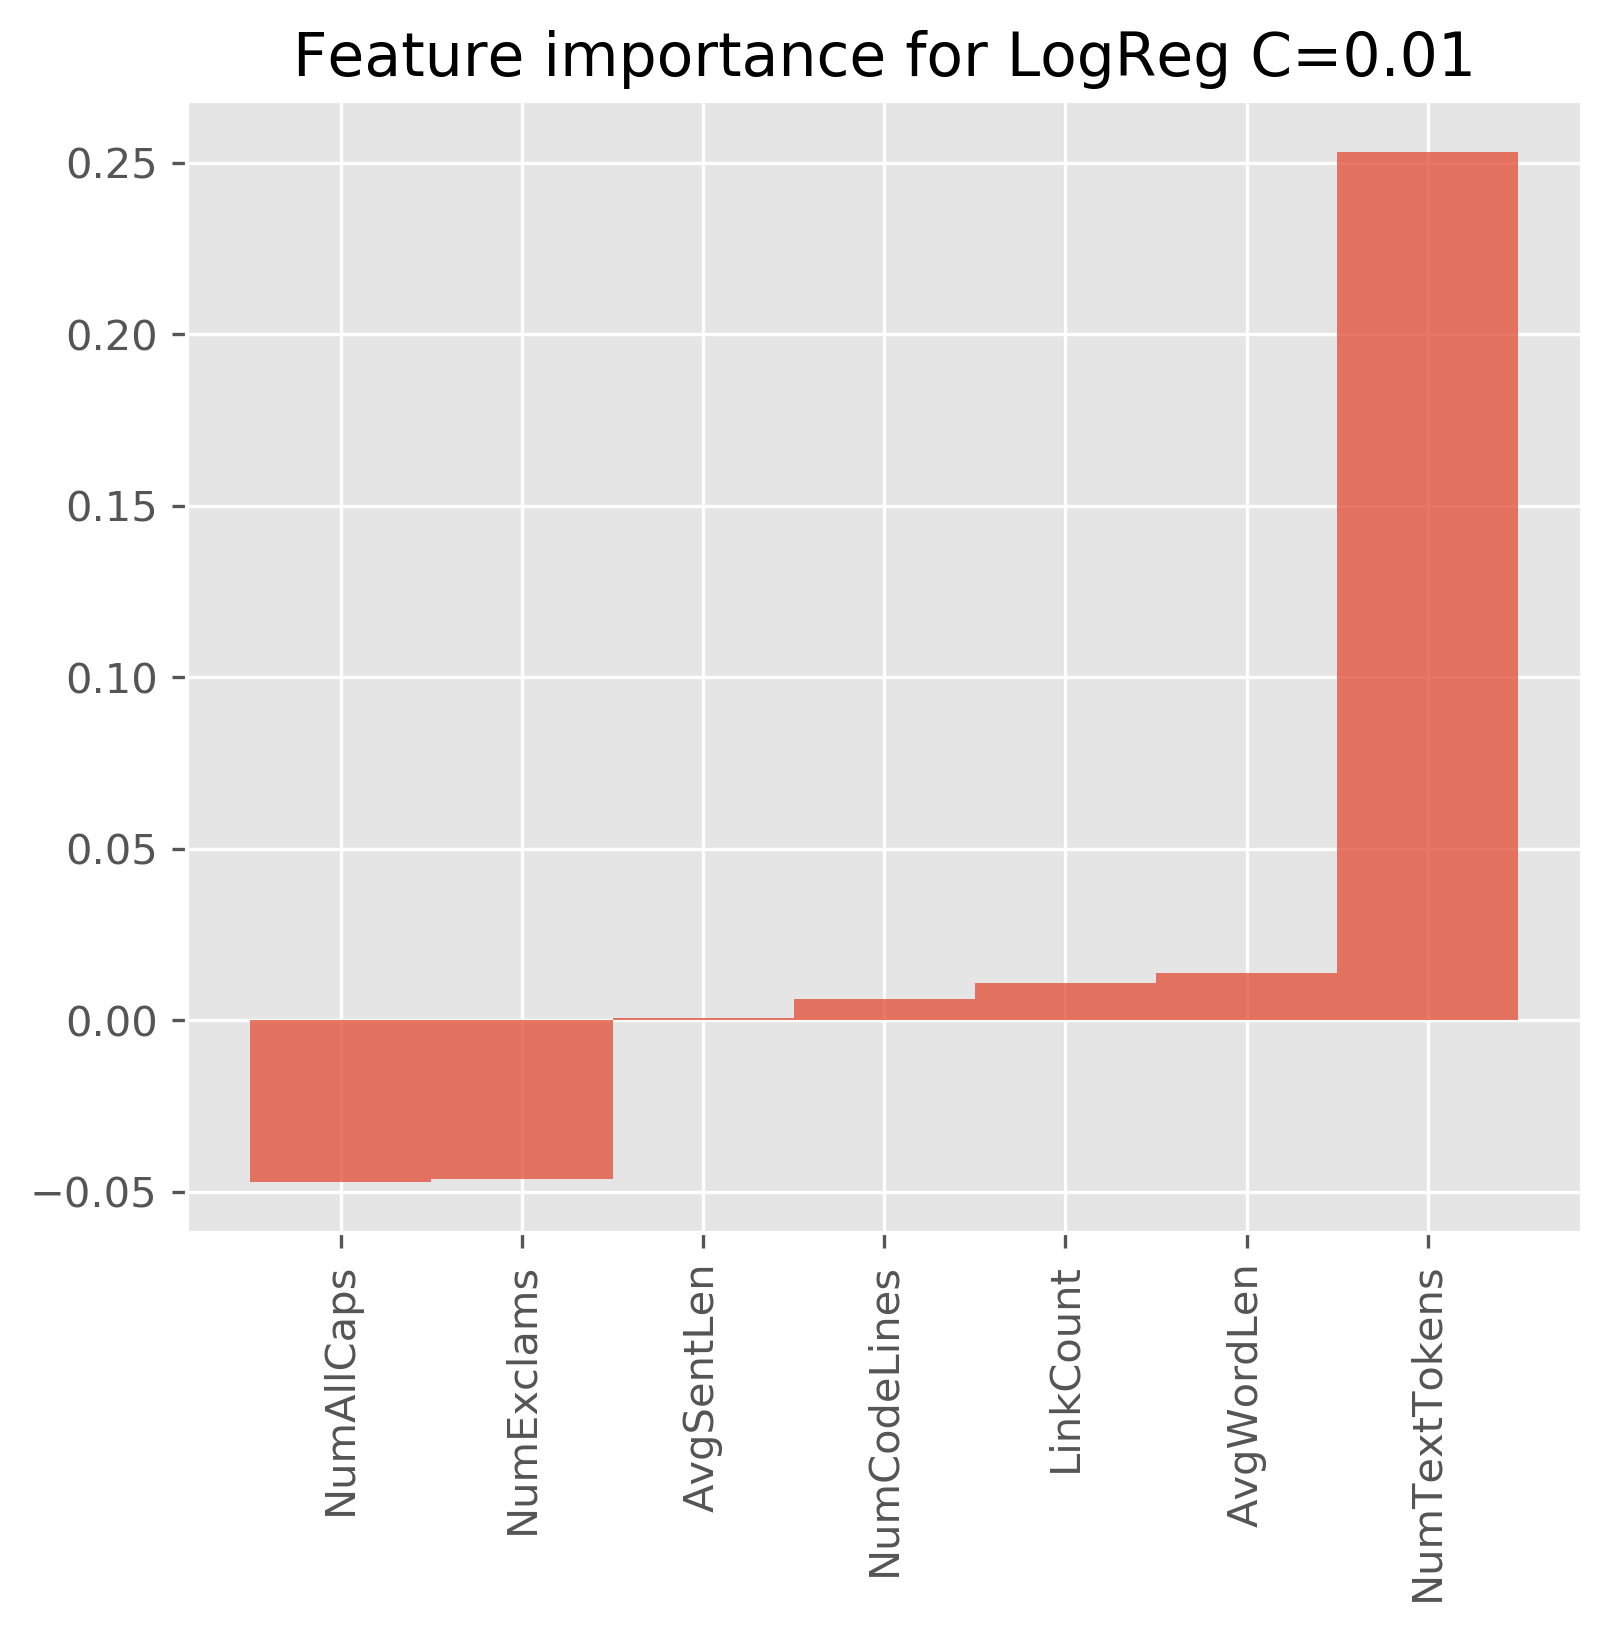

In [36]:
feature_names = np.array((
    'NumTextTokens',
    'NumCodeLines',
    'LinkCount',
    'AvgSentLen',
    'AvgWordLen',
    'NumAllCaps',
    'NumExclams'
))

X_orig = np.asarray([get_features(aid, ['LinkCount', 'NumCodeLines', 'NumTextTokens', 'AvgSentLen', 'AvgWordLen', 'NumAllCaps', 'NumExclams']) for aid in all_answers])

Y_orig_good = np.asarray([meta[aid]['Score'] > 0 for aid in all_answers])
Y_orig_poor = np.asarray([meta[aid]['Score'] <= 0 for aid in all_answers])

X_new, Y_good, Y_poor = shuffle(X_orig, Y_orig_good, Y_orig_poor, random_state=0)
    
name = "LogReg C=%.2f" % C_best

print("Good answers...")
_, _, good_results = measure(LogisticRegression, {'C': C_best}, '08_good_'+name, X_new, Y_good, plot='good', feature_names=feature_names)

Poor answers...


C:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Anaconda3\lib\site-packages

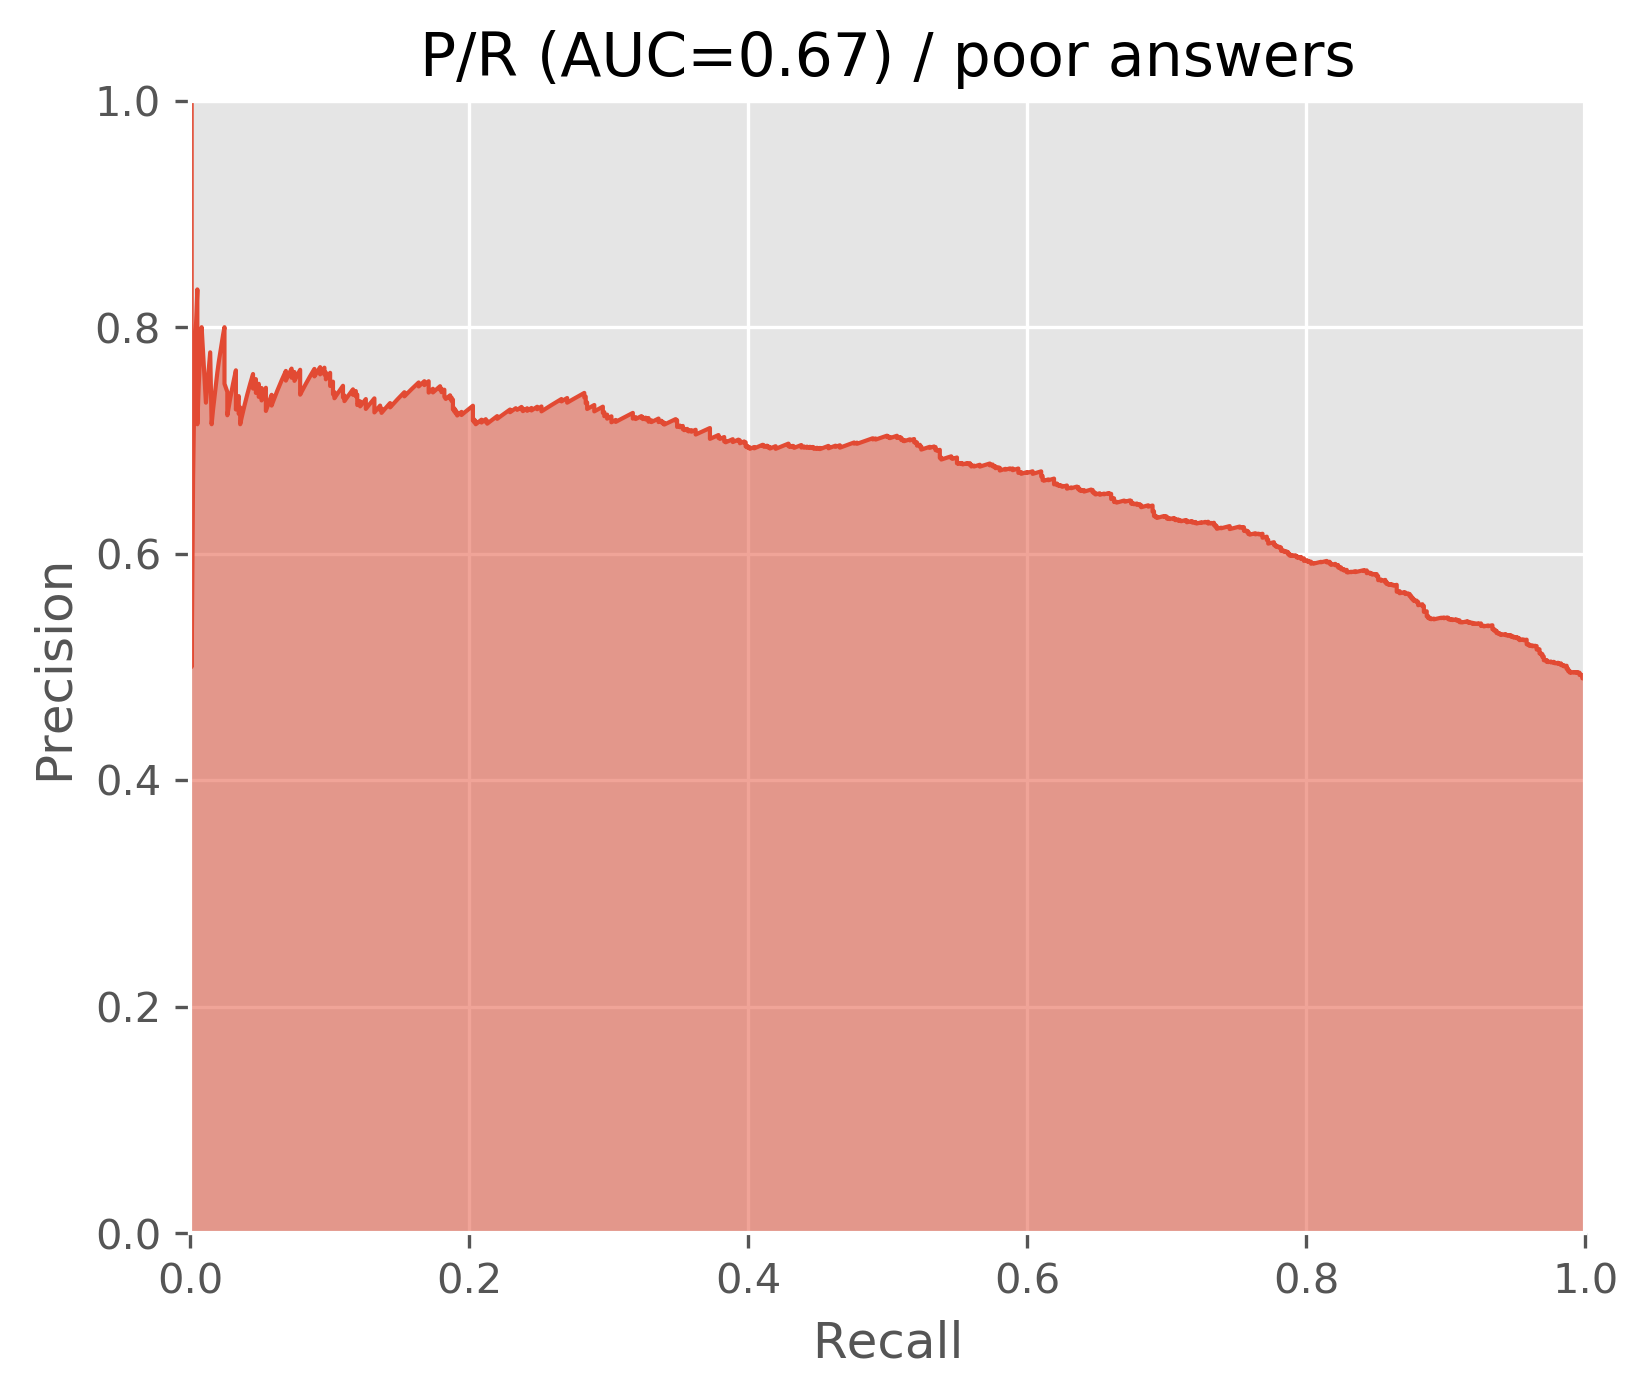

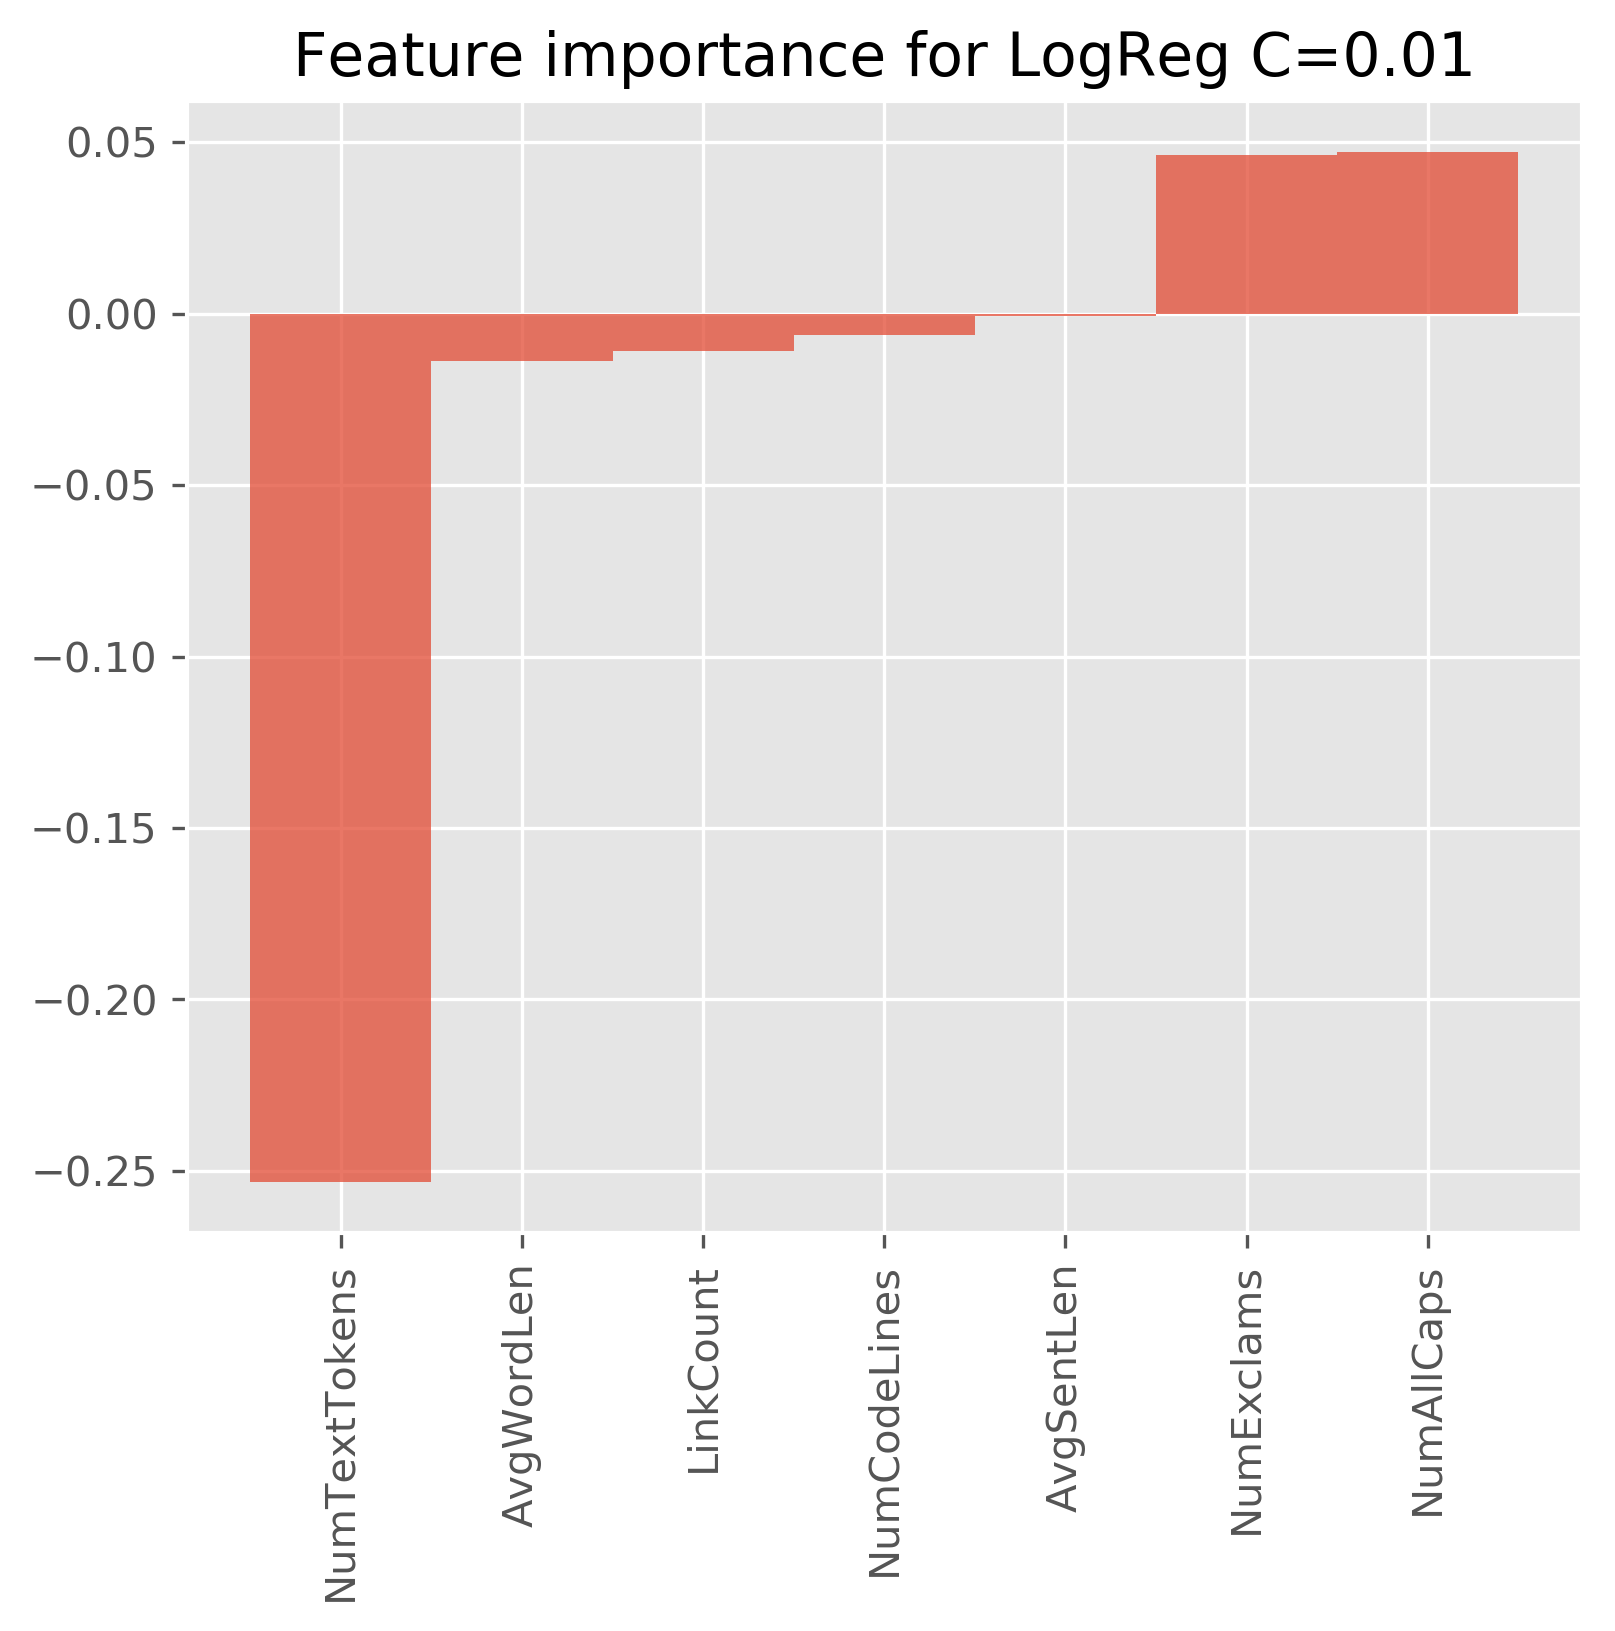

In [37]:
print("Poor answers...")
measure(LogisticRegression, {'C': C_best}, '09_poor_'+name, X_new, Y_poor, plot='poor', feature_names=feature_names);

In [38]:
precisions = good_results['med_precisions']
recalls = good_results['med_recalls']
thresholds = np.hstack([[0], good_results['med_thresholds']])

for precision in np.arange(0.77, 0.8, 0.01):
    thresh_idx = precisions >= precision
    print("P=%.2f R=%.2f thresh=%.2f" % (precisions[thresh_idx][0], recalls[thresh_idx][0], thresholds[thresh_idx][0]))

P=0.77 R=0.30 thresh=0.59
P=0.78 R=0.29 thresh=0.60
P=0.79 R=0.28 thresh=0.61
P=0.80 R=0.15 thresh=0.70


In [39]:
good_thresh = 0.66

# Ship it!

In [40]:
clf = LogisticRegression(C=C_best)
clf.fit(X, Y)
print(clf.coef_)

C:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[[ 0.27262106  0.00675757  0.0104575   0.00085275  0.01928719 -0.04109458
  -0.0513559 ]]


In [41]:
import pickle
pickle.dump(clf, open("logreg.dat", "wb"))
clf = pickle.load(open("logreg.dat", "rb"))
print(clf.coef_)

[[ 0.27262106  0.00675757  0.0104575   0.00085275  0.01928719 -0.04109458
  -0.0513559 ]]


We can now use the classifier's `predict_proba()` to calculate the probabilities for the classes `poor` and `good`:

In [42]:
# Remember that the features are in this order:
# LinkCount, NumCodeLines, NumTextTokens, AvgSentLen, AvgWordLen, NumAllCaps, NumExclams
good_post = (2, 1, 100, 5, 4, 1, 0)
poor_post = (1, 0, 10, 5, 6, 5, 4)
proba = clf.predict_proba([good_post, poor_post])
proba

array([[0.28211369, 0.71788631],
       [0.64971358, 0.35028642]])

In [43]:
proba >= good_thresh

array([[False,  True],
       [False, False]])

As expected, we manage to detect the first post as good, but cannot say anything about the second, which is why we would show some nice motivating message to improve the post.

## Classification with Tensorflow

We can also create a simple neural network with Tensorflow. As we already have the features, we can create a simple one with just one so-called hidden layer.

In [48]:
import tensorflow as tf

In [49]:
X = np.asarray([get_features(aid, ['LinkCount', 'NumCodeLines', 'NumTextTokens', 'AvgSentLen', 'AvgWordLen', 'NumAllCaps', 'NumExclams']) for aid in all_answers])
Y = np.asarray([meta[aid]['Score'] > 0 for aid in all_answers])

In [51]:
Y

array([ True, False,  True, ...,  True, False, False])

We first covert the output reference. We want to target a probability as close as possible to 0 and 1, but as we use a sigmoid for the output layer that matches -inf to 0 and +inf to 1, we clamp instead to a small value.

In [52]:
Y = Y.astype(np.float32)[:, None]
bce_ceil = 1e-5
Y = Y * (1 - 2 * bce_ceil) + bce_ceil
Y

array([[9.9999e-01],
       [1.0000e-05],
       [9.9999e-01],
       ...,
       [9.9999e-01],
       [1.0000e-05],
       [1.0000e-05]], dtype=float32)

We know split the data in train/test arrays.

In [54]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.8, test_size=0.2)

Let's create helper functions to create the layers. We don't need them now, but they are useful for playing with the network.

In [55]:
def create_dense(x, n_units, name, alpha=0.2):
    # Hidden layer
    h = tf.layers.dense(x, n_units, activation=tf.nn.leaky_relu, name=name)
    return h

def create_output(x):
    # Output layer
    h = tf.layers.dense(x, 1, activation=tf.nn.sigmoid, name="Output")
    return h

In [56]:
tf.reset_default_graph()

n_epochs = 500
batch_size = 1000
steps = 10
layer1_size = 5

Just as before, we can now create placeholders, and we will use our helper functions to create implicit variables.

In [57]:
X_tf = tf.placeholder(tf.float32, (None, 7), name="Input")
Y_ref_tf = tf.placeholder(tf.float32, (None, 1), name="Target_output")

h1 = create_dense(X_tf, layer1_size, name="Layer1")
Y_tf = create_output(h1)

loss = tf.reduce_mean(tf.square(Y_ref_tf - Y_tf))

grad_speed = .01
my_opt = tf.train.GradientDescentOptimizer(grad_speed)
train_step = my_opt.minimize(loss)

Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


And now for the training session

In [58]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    loss_vec = []
    for epoch in range(n_epochs):
        permut = np.random.permutation(len(X_train))
        for j in range(0, len(X_train), batch_size):
            batch = permut[j:j+batch_size]
            Xs = X_train[batch]
            Ys = Y_train[batch]
            
            sess.run(train_step, feed_dict={X_tf: Xs, Y_ref_tf: Ys})
        
        temp_loss = sess.run(loss, feed_dict={X_tf: X_train, Y_ref_tf: Y_train})
        loss_vec.append(temp_loss)
        if epoch % steps == steps - 1:
            print('Epoch #%i  loss = %s' % (epoch, temp_loss))

    predict_train = sess.run(Y_tf, feed_dict={X_tf: X_train})
    predict_test = sess.run(Y_tf, feed_dict={X_tf: X_test})

Epoch #9  loss = 0.4402765
Epoch #19  loss = 0.24054688
Epoch #29  loss = 0.24426645
Epoch #39  loss = 0.22896501
Epoch #49  loss = 0.23083127
Epoch #59  loss = 0.22662607
Epoch #69  loss = 0.2274471
Epoch #79  loss = 0.24156597
Epoch #89  loss = 0.22559403
Epoch #99  loss = 0.22935608
Epoch #109  loss = 0.22445561
Epoch #119  loss = 0.22475177
Epoch #129  loss = 0.22493052
Epoch #139  loss = 0.22473179
Epoch #149  loss = 0.22705002
Epoch #159  loss = 0.22700739
Epoch #169  loss = 0.22427724
Epoch #179  loss = 0.2267863
Epoch #189  loss = 0.22333942
Epoch #199  loss = 0.22308557
Epoch #209  loss = 0.22643888
Epoch #219  loss = 0.22320259
Epoch #229  loss = 0.22383767
Epoch #239  loss = 0.2229767
Epoch #249  loss = 0.22359285
Epoch #259  loss = 0.22385615
Epoch #269  loss = 0.22268516
Epoch #279  loss = 0.22308691
Epoch #289  loss = 0.22311908
Epoch #299  loss = 0.22311267
Epoch #309  loss = 0.22356422
Epoch #319  loss = 0.22236118
Epoch #329  loss = 0.22470672
Epoch #339  loss = 0.2226

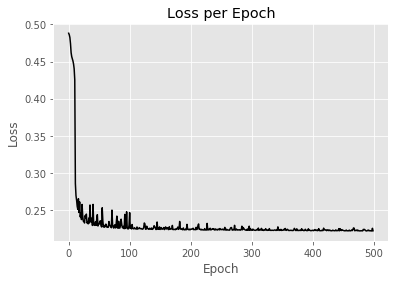

In [59]:
plt.plot(loss_vec, 'k-')
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
save_png('tf_classification_loss')

Now for the results for this new classifier:

In [60]:
from sklearn.metrics import accuracy_score

score = accuracy_score(Y_train > .5, predict_train > .5)
print("Score (on training data): %.2f" % score)
score = accuracy_score(Y_test > .5, predict_test > .5)
print("Score (on testing data): %.2f" % score)

Score (on training data): 0.65
Score (on testing data): 0.66


We can very similar results to the other classifiers. It is now a good time to play with this neural network by changing the number of units inside the layer, adding a new layer, using different number of units for each layer, perhaps also changing the activation.

Before going to the next chapter, we can also display the confusion matrix thanks to a small function from scikit learn tutorials.

In [61]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    import itertools
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

              precision    recall  f1-score   support

        Poor       0.64      0.67      0.65      7993
        Good       0.65      0.63      0.64      8007

   micro avg       0.65      0.65      0.65     16000
   macro avg       0.65      0.65      0.65     16000
weighted avg       0.65      0.65      0.65     16000

Confusion matrix, without normalization
[[5329 2664]
 [2983 5024]]


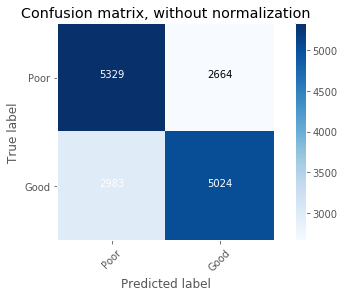

              precision    recall  f1-score   support

        Poor       0.66      0.67      0.67      2007
        Good       0.66      0.65      0.66      1993

   micro avg       0.66      0.66      0.66      4000
   macro avg       0.66      0.66      0.66      4000
weighted avg       0.66      0.66      0.66      4000

Confusion matrix, without normalization
[[1353  654]
 [ 696 1297]]


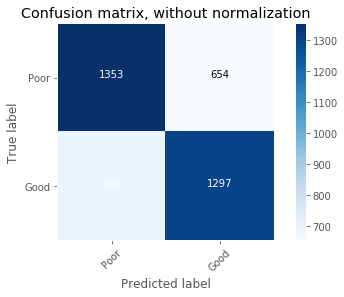

In [62]:
class_names = ["Poor", "Good"]
from sklearn import metrics
print(metrics.classification_report(Y_train > .5, predict_train > .5, target_names=class_names))
plot_confusion_matrix(metrics.confusion_matrix(Y_train > .5, predict_train > .5), classes=class_names,
                      title='Confusion matrix, without normalization')
plt.grid(False)
save_png('tf_classification_train')
plt.show()
print(metrics.classification_report(Y_test > .5, predict_test > .5, target_names=class_names))
plot_confusion_matrix(metrics.confusion_matrix(Y_test > .5, predict_test > .5), classes=class_names,
                      title='Confusion matrix, without normalization')
plt.grid(False)
save_png('tf_classification_test')